<a href="https://colab.research.google.com/github/lourencocavalcante/CAP-421-3-Deep-Learning/blob/main/CAP_421_DeepLeraning_Model_MLP_NowcastingRainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-730 Aprendizado Profundo (*Deep Leraning*)**
## **Otimizando redes neurais recorrentes para previsão de chuva com dados desbalanceados**

**Docentes:** *Dr. Valdivino Alexandre de Santiago Junior, Dr. Elcio Hideiti Shiguemori e Dr. Thales Sehn Körti*

**Discente:** *Lourenço José Cavalcante Neto*

---



## Resumo
*A previsão de chuva a curto prazo é essencial para diversos setores, como a agricultura e companhias aéreas, entre outros. Nesse contexto, modelos de previsão baseados em Inteligência Artificial (IA) têm se destacado. No entanto, um problema recorrente está relacionado à qualidade dos dados utilizados no treinamento desses modelos, especialmente no caso de dados de precipitação. Em [2], foi realizado um estudo sobre o desbalanceamento dados meteorológicos, associados a diferentes sistemas precipitantes observados [9], e sua influência na capacidade preditiva de um modelo de previsão de chuva usando uma rede neural MLP (Multilayer Perceptron). O desbalanceamnerto pode levar a estimativas enviesadas, favorecendo certos tipos de chuva em detrimento de outros. Por exemplo, chuvas mais fracas podem ser sobre-representadas em comparação com chuvas mais fortes, que são menos frequentes. Embora o estudo tenha evidenciado a importância de se utilizar dados confiáveis para o treinamento do modelo, MLPs não conseguem capturar adequadamente as dependências temporais e os padrões sequenciais dos dados. Isso sugere a necessidade de investigações adicionais, em que uma abordagem usando métodos de aprendizado profundo (Deep Learnig) pode ser um ponto de partida. Assim, o objetivo deste trabalho será explorar um tipo específico de rede neural recorrente, especificamente uma LSTM (Long Short-Term Memory) [5], cuja arquitetura é mais adequada para lidar com dependências de longo prazo em séries temporais [8]. Será avaliado o desempenho da LSTM em comparação aos resultados obtidos com a MLP em [2], no mesmo contexto de dados, em que pesos serão aplicados à perda do modelo para cada amostra durante o treinamento, levando em consideração a intensidade da chuva (mm/h). Os dados estão em formato tabular e foram coletados por quatro sensores meteorológicos: um disdrômetro de impacto Joss-Waldvogel [6], um disdrômetro a laser PARSIVEL2 (Particle Size and Velocity) [7], um pluviômetro automático [4] e um radiômetro de micro-ondas terrestre [3]. Os sensores estão instalados no experimento de campo campina, que faz parte do projeto Amazon Tall Tower Observatory (ATTO) [1].*

## **Importando módulos e bibliotecas**
Em Python, as bibliotecas são importadas convencionalmente, conforme mostrado/aplicado na célula abaixo:

In [1]:
!pip list | grep tensorflow

tensorflow                         2.17.0
tensorflow-datasets                4.9.6
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.16.0
tensorflow-probability             0.24.0


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import math
import calendar
import datetime
import glob
import os
import pathlib
import random

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.metrics import RootMeanSquaredError
from keras.regularizers import l2
from keras.optimizers import SGD
from keras import regularizers


# Definr a fonte padrão para uma fonte Times paera as figuras
plt.rcParams['font.family'] = 'serif'

## **Conjunto de dados**

Os dados meteorológicos são oriundos de 4 instrumentos:**(Radiômetro de Micro-ondas "MP3000A", Pluviômetro, Disdrômetro "RD80" e Disdrômetro "Parsivel2")**. Todos instalados próximos à torre ATTO, no experimento de campo Campina, na região amazônica.

Os dados abrangem o período de outubro de 2020 a novembro de 2023.

Lendo o conjunto de dados do **GoogleDrive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Carregando os dados meteorológicos de teste para Campina (ATTO)
df_complete = pd.read_table('/content/drive/MyDrive/DoutoradoCAP-INPE/DeepLearning/Data/df_final_for_model.txt', sep='\t')
# Convertendo a coluna "Datetime" para um objeto datetime
df_complete['Datetime'] = pd.to_datetime(df_complete['Datetime'])
# Definindo a coluna "Datetime" como o índice
df_complete.set_index("Datetime", inplace=True)
# Convertendo todas as colunas para numérico, tratando erros como NaN
df_complete = df_complete.apply(pd.to_numeric, errors='coerce')


In [7]:
df_complete.columns

Index(['Tamb_k', 'Relative_humidity', 'Pres_mb', 'Tir_K', 'Az_deg', 'El_deg',
       'TkBB_K', '22.234GHz', '22.500GHz', '23.034GHz', '23.834GHz',
       '25.000GHz', '26.234GHz', '28.000GHz', '30.000GHz', '51.248GHz',
       '51.760GHz', '52.280GHz', '52.804GHz', '53.336GHz', '53.848GHz',
       '54.400GHz', '54.940GHz', '55.500GHz', '56.020GHz', '56.660GHz',
       '57.288GHz', '57.964GHz', '58.800GHz', 'Raingauge_RR_after_mm',
       'Joss_RR_after_mm', 'Pars_RR_after_mm', 'Raingauge_RR_mm_h',
       'Joss_RR_mm_h', 'Pars_RR_mm_h', 'Rainfall_mm_h', 'Class_Rain',
       'Datetime.1', 'Year', 'Month'],
      dtype='object')

In [8]:
df_complete_copy = df_complete.drop(columns=['Az_deg', 'El_deg', 'Datetime.1', 'Year', 'Month','Raingauge_RR_after_mm',
       'Joss_RR_after_mm', 'Pars_RR_after_mm', 'Raingauge_RR_mm_h',
       'Joss_RR_mm_h', 'Pars_RR_mm_h'])

In [9]:
df_copy = df_complete_copy.copy()

In [10]:
df_copy

Tamb_k  Relative_humidity      Pres_mb       Tir_K  \
Datetime                                                                      
2021-07-27 18:00:00  294.946522          55.664565  1007.527391  251.280000   
2021-07-27 19:00:00  294.996833          54.656833  1006.875000  251.280000   
2021-07-27 20:00:00  295.091667          55.201500  1006.325000  251.280000   
2021-07-27 21:00:00  295.208667          58.422000  1006.286667  251.280000   
2021-07-27 22:00:00  295.226500          58.598500  1006.465000  251.280000   
...                         ...                ...          ...         ...   
2023-11-27 05:00:00  295.946000          99.054833  1006.105000  262.234667   
2023-11-27 06:00:00  295.826500          99.104167  1005.533333  262.678333   
2023-11-27 07:00:00  295.950167          99.335833  1005.861667  272.742833   
2023-11-27 08:00:00  297.172833          97.220667  1006.863333  291.185833   
2023-11-27 09:00:00  296.999000          98.000000  1007.160000  287.674000   

                         TkBB_K  22.234GHz  22.500GHz  23.034GHz  23.834GHz  \
Datetime                                                                      
2021-07-27 18:00:00  307.508130  60.778000  60.238000  53.650000  47.836000   
2021-07-27 19:00:00  308.251100  60.778000  60.238000  53.650000  47.836000   
2021-07-27 20:00:00  308.642883  60.778000  60.238000  53.650000  47.836000   
2021-07-27 21:00:00  308.851067  60.778000  60.238000  53.650000  47.836000   
2021-07-27 22:00:00  308.888067  60.778000  60.238000  53.650000  47.836000   
...                         ...        ...        ...        ...        ...   
2023-11-27 05:00:00  310.622033  71.099417  66.556650  55.457750  50.215650   
2023-11-27 06:00:00  310.574133  70.776750  66.231283  55.062933  49.927817   
2023-11-27 07:00:00  310.397733  73.875933  69.355950  58.413717  53.132550   
2023-11-27 08:00:00  310.849133  76.655283  72.427367  61.494500  56.015783   
2023-11-27 09:00:00  311.327200  73.256700  68.730500  57.443100  51.976300   

                     25.000GHz  ...   54.400GHz   54.940GHz   55.500GHz  \
Datetime                        ...                                       
2021-07-27 18:00:00  27.565000  ...  296.368000  296.882000  297.941000   
2021-07-27 19:00:00  27.565000  ...  296.368000  296.882000  297.941000   
2021-07-27 20:00:00  27.565000  ...  296.368000  296.882000  297.941000   
2021-07-27 21:00:00  27.565000  ...  296.368000  296.882000  297.941000   
2021-07-27 22:00:00  27.565000  ...  296.368000  296.882000  297.941000   
...                        ...  ...         ...         ...         ...   
2023-11-27 05:00:00  25.975000  ...  280.721717  289.997700  292.740467   
2023-11-27 06:00:00  25.674717  ...  280.536200  289.904983  292.548383   
2023-11-27 07:00:00  28.809567  ...  280.743983  289.694133  292.306617   
2023-11-27 08:00:00  31.900950  ...  280.650417  289.379367  291.823567   
2023-11-27 09:00:00  27.141500  ...  279.953900  289.154600  291.794900   

                      56.020GHz   56.660GHz   57.288GHz   57.964GHz  \
Datetime                                                              
2021-07-27 18:00:00  299.311957  299.671000  299.416978  299.607913   
2021-07-27 19:00:00  299.392367  299.834067  299.704350  299.754067   
2021-07-27 20:00:00  299.409617  299.868367  299.765233  299.972033   
2021-07-27 21:00:00  299.195817  299.883367  299.711917  299.821083   
2021-07-27 22:00:00  299.365350  299.750950  299.509117  299.760450   
...                         ...         ...         ...         ...   
2023-11-27 05:00:00  294.008767  294.556250  294.368383  294.811083   
2023-11-27 06:00:00  293.947733  294.434067  294.213383  294.591567   
2023-11-27 07:00:00  293.669000  294.124100  293.920900  294.417967   
2023-11-27 08:00:00  293.092567  293.628400  293.380917  293.942350   
2023-11-27 09:00:00  293.111400  293.831300  293.327200  294.080100   

                      58.800GHz  Rainfall_mm_h  Class_Rain  
Datetime

## Dataset for news test last validation model

# Resample data RAIN para calcular a média diária


In [11]:
# Calculate NaN percentages for each column
nan_counts = df_copy.isna().sum()
nan_percentages = (nan_counts / len(df_copy)) * 100

# Drop columns with NaN percentage >= 100%
columns_to_drop = nan_percentages[nan_percentages >= 100].index
df_copy.drop(columns=columns_to_drop, inplace=True)

In [12]:
# Check for NaN values in df_rain_final
nan_counts = df_copy.isna().sum()
nan_columns = nan_counts[nan_counts > 0].index.tolist()

if len(nan_columns) > 0:
    print("Columns with NaN values:")
    for column in nan_columns:
        nan_percentage = np.round((nan_counts[column] / len(df_copy)) * 100, 2)
        print(f"{column}: {nan_counts[column]} NaN values ({nan_percentage}%)")
else:
    print("No NaN values in weather_station_df_filter.")
    for column in nan_columns:
        nan_percentage = np.round((nan_counts[column] / len(df_copy)) * 100, 2)
        print(f"{column}: {nan_counts[column]} NaN values ({nan_percentage}%)")

No NaN values in weather_station_df_filter.


In [13]:
# Check for duplicate indices
df_copy.sort_index(inplace=True)
duplicated_indices = df_copy.index.duplicated(keep=False)

# Filter and display the duplicate rows
if any(duplicated_indices):
    print("Duplicate indices found:")
    print(df_copy[duplicated_indices])
else:
    print("No duplicate indices in the DataFrame.")

No duplicate indices in the DataFrame.


In [14]:
df_copy = df_copy[~df_copy.index.duplicated(keep='first')]

In [15]:
# Usando .isna() ou .isnull() para criar uma máscara de valores NaN
nan_mask = df_copy.isna()

# Usando .sum() para contar os valores True (NaN) em cada coluna
nan_count = nan_mask.sum()

# nan_count agora contém o número de NaN em cada coluna
print(nan_count)

Tamb_k               0
Relative_humidity    0
Pres_mb              0
Tir_K                0
TkBB_K               0
22.234GHz            0
22.500GHz            0
23.034GHz            0
23.834GHz            0
25.000GHz            0
26.234GHz            0
28.000GHz            0
30.000GHz            0
51.248GHz            0
51.760GHz            0
52.280GHz            0
52.804GHz            0
53.336GHz            0
53.848GHz            0
54.400GHz            0
54.940GHz            0
55.500GHz            0
56.020GHz            0
56.660GHz            0
57.288GHz            0
57.964GHz            0
58.800GHz            0
Rainfall_mm_h        0
Class_Rain           0
dtype: int64


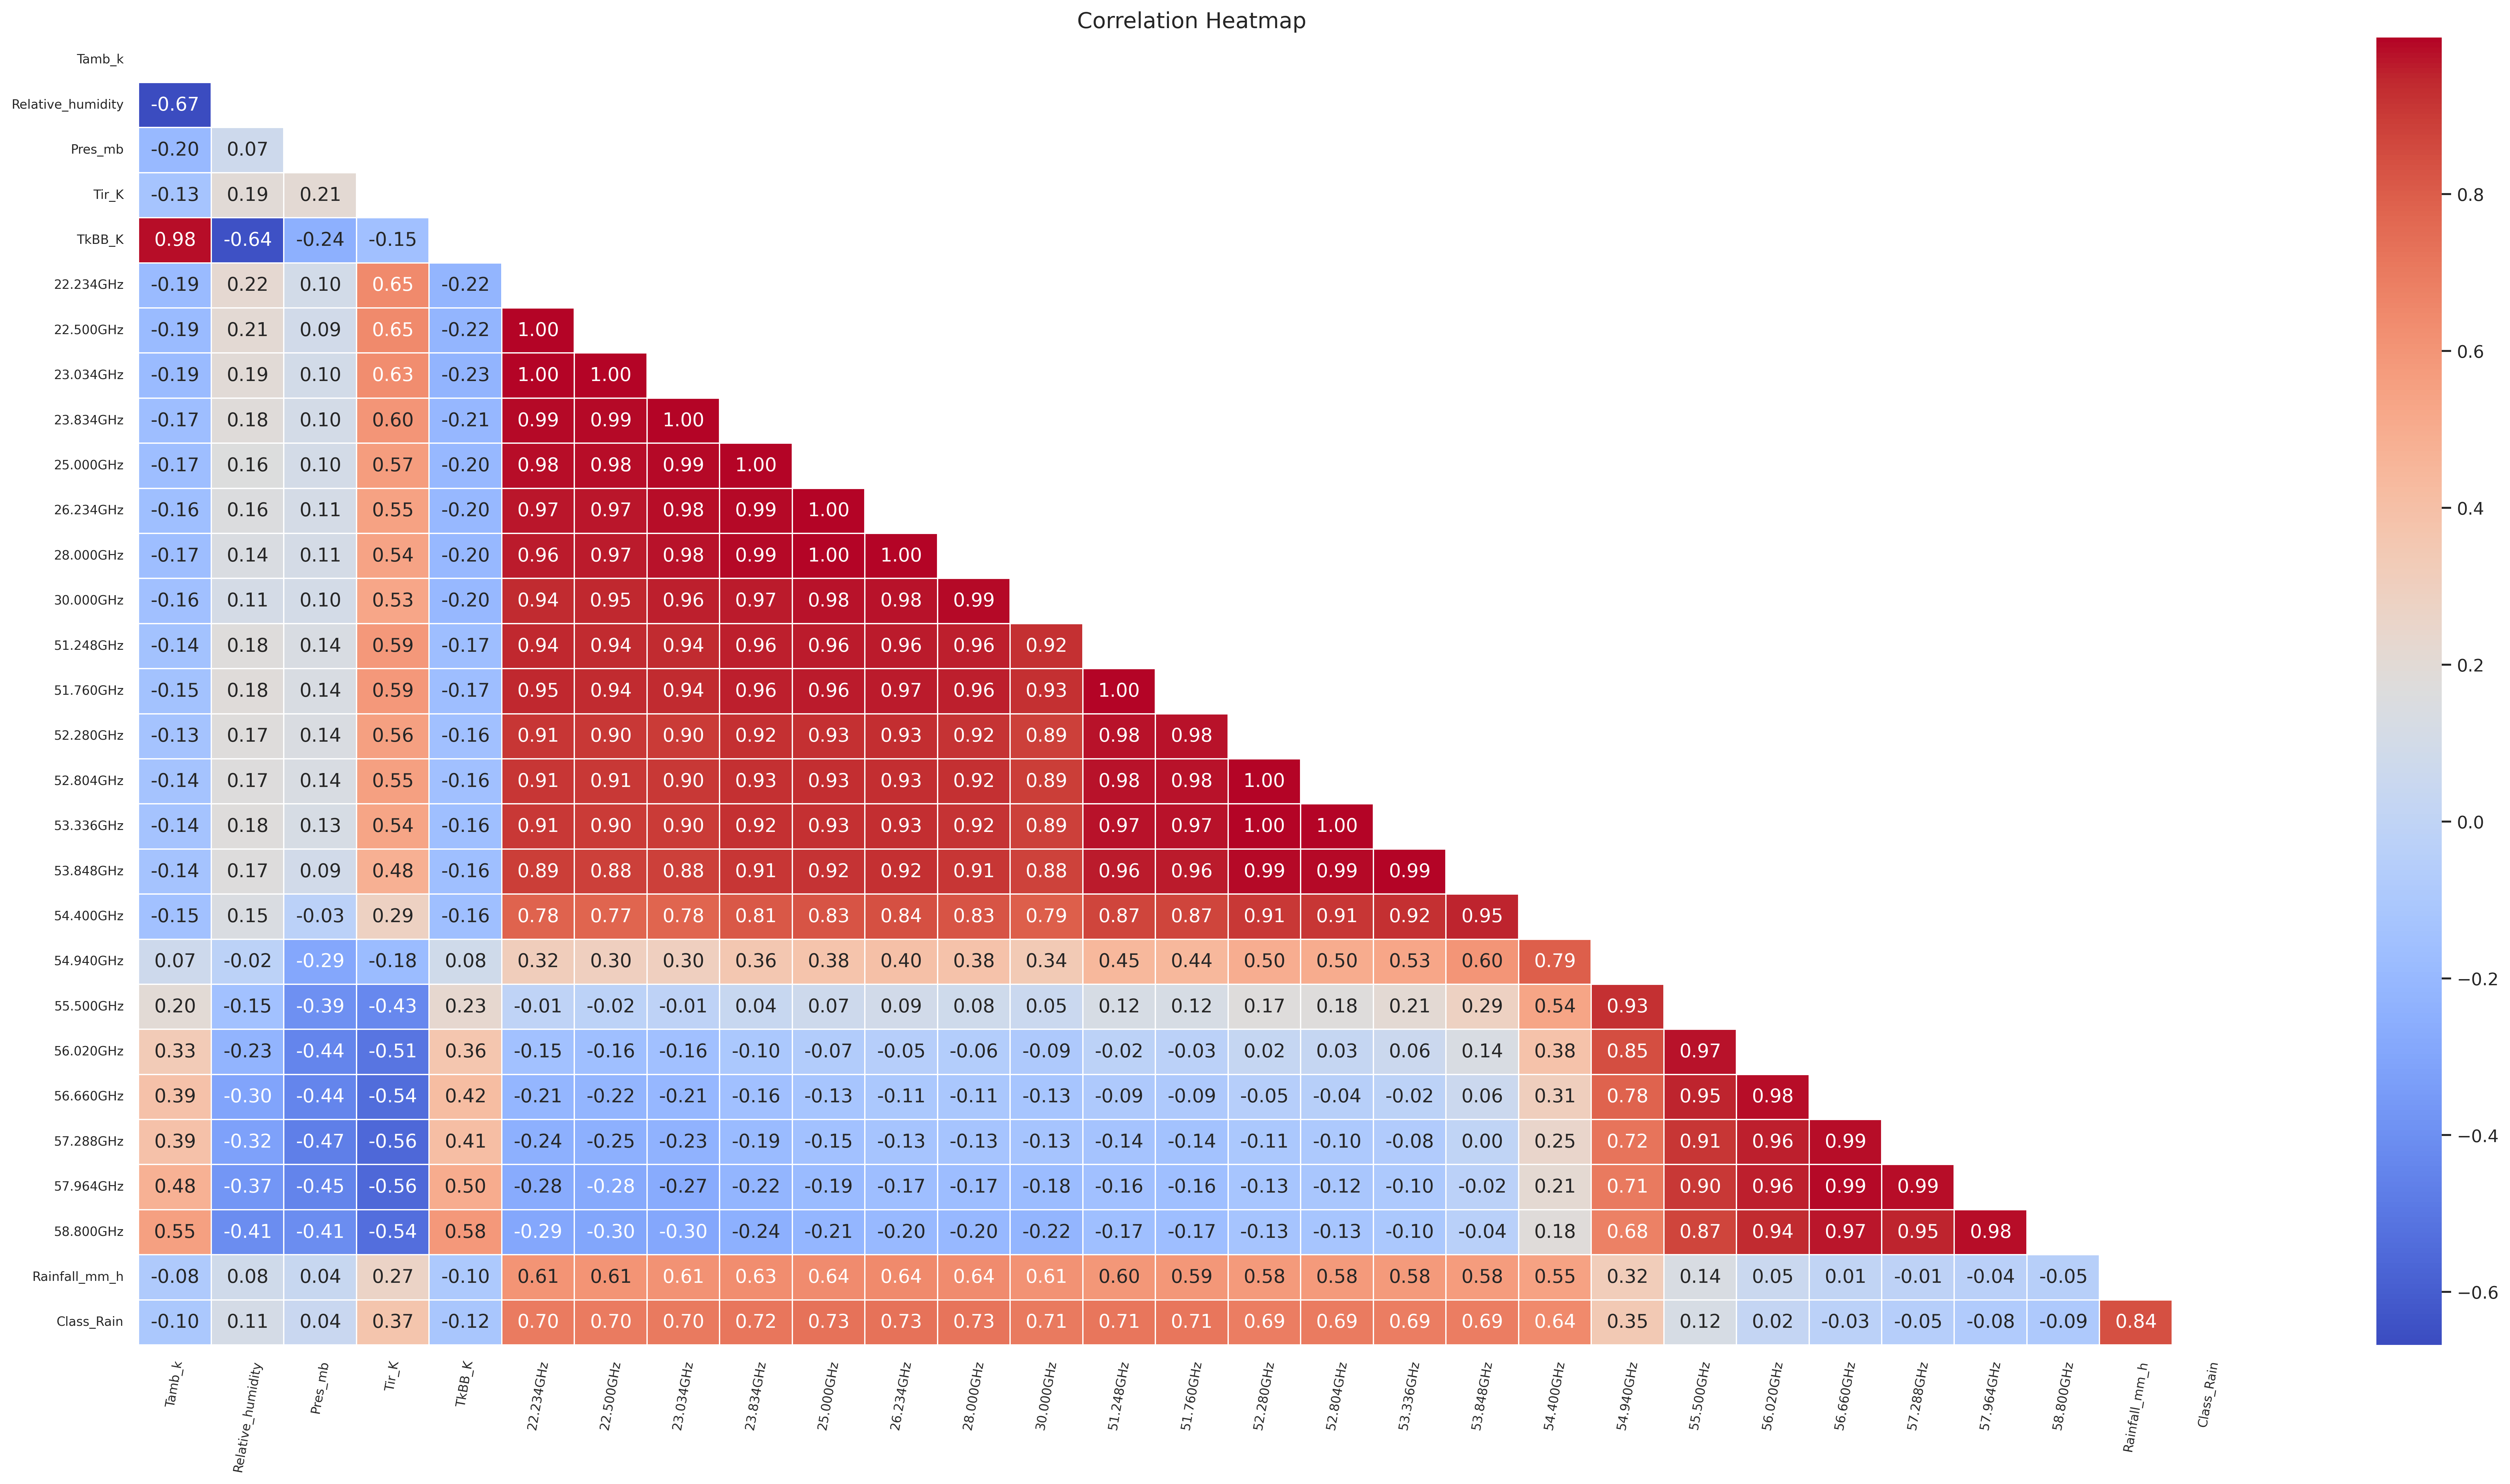

In [17]:
# Calcular a matriz de correlação diretamente em df_final
correlation_matrix = df_copy.corr(method='pearson') #spearman

# Configurar estilo para o gráfico
sns.set(style="white")

# Criar uma máscara para mostrar apenas a metade superior da matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Obter os nomes das variáveis presentes no DataFrame
nomes_variaveis = df_copy.columns

# Criar o gráfico de heatmap
plt.figure(figsize=(30, 15), dpi=350)
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Heatmap', fontsize=14)
#plt.ylabel('Variáveis', fontsize=9)
#plt.xlabel('Variáveis', fontsize=9)

# Definir rótulos personalizados para os eixos Y e X com os nomes das variáveis
plt.yticks(np.arange(len(nomes_variaveis)) + 0.5, nomes_variaveis, fontsize=8, va='center')
plt.xticks(np.arange(len(nomes_variaveis)) + 0.5, nomes_variaveis, fontsize=8, rotation=80, ha='center')

plt.show()


In [19]:
df_final = df_copy.copy()

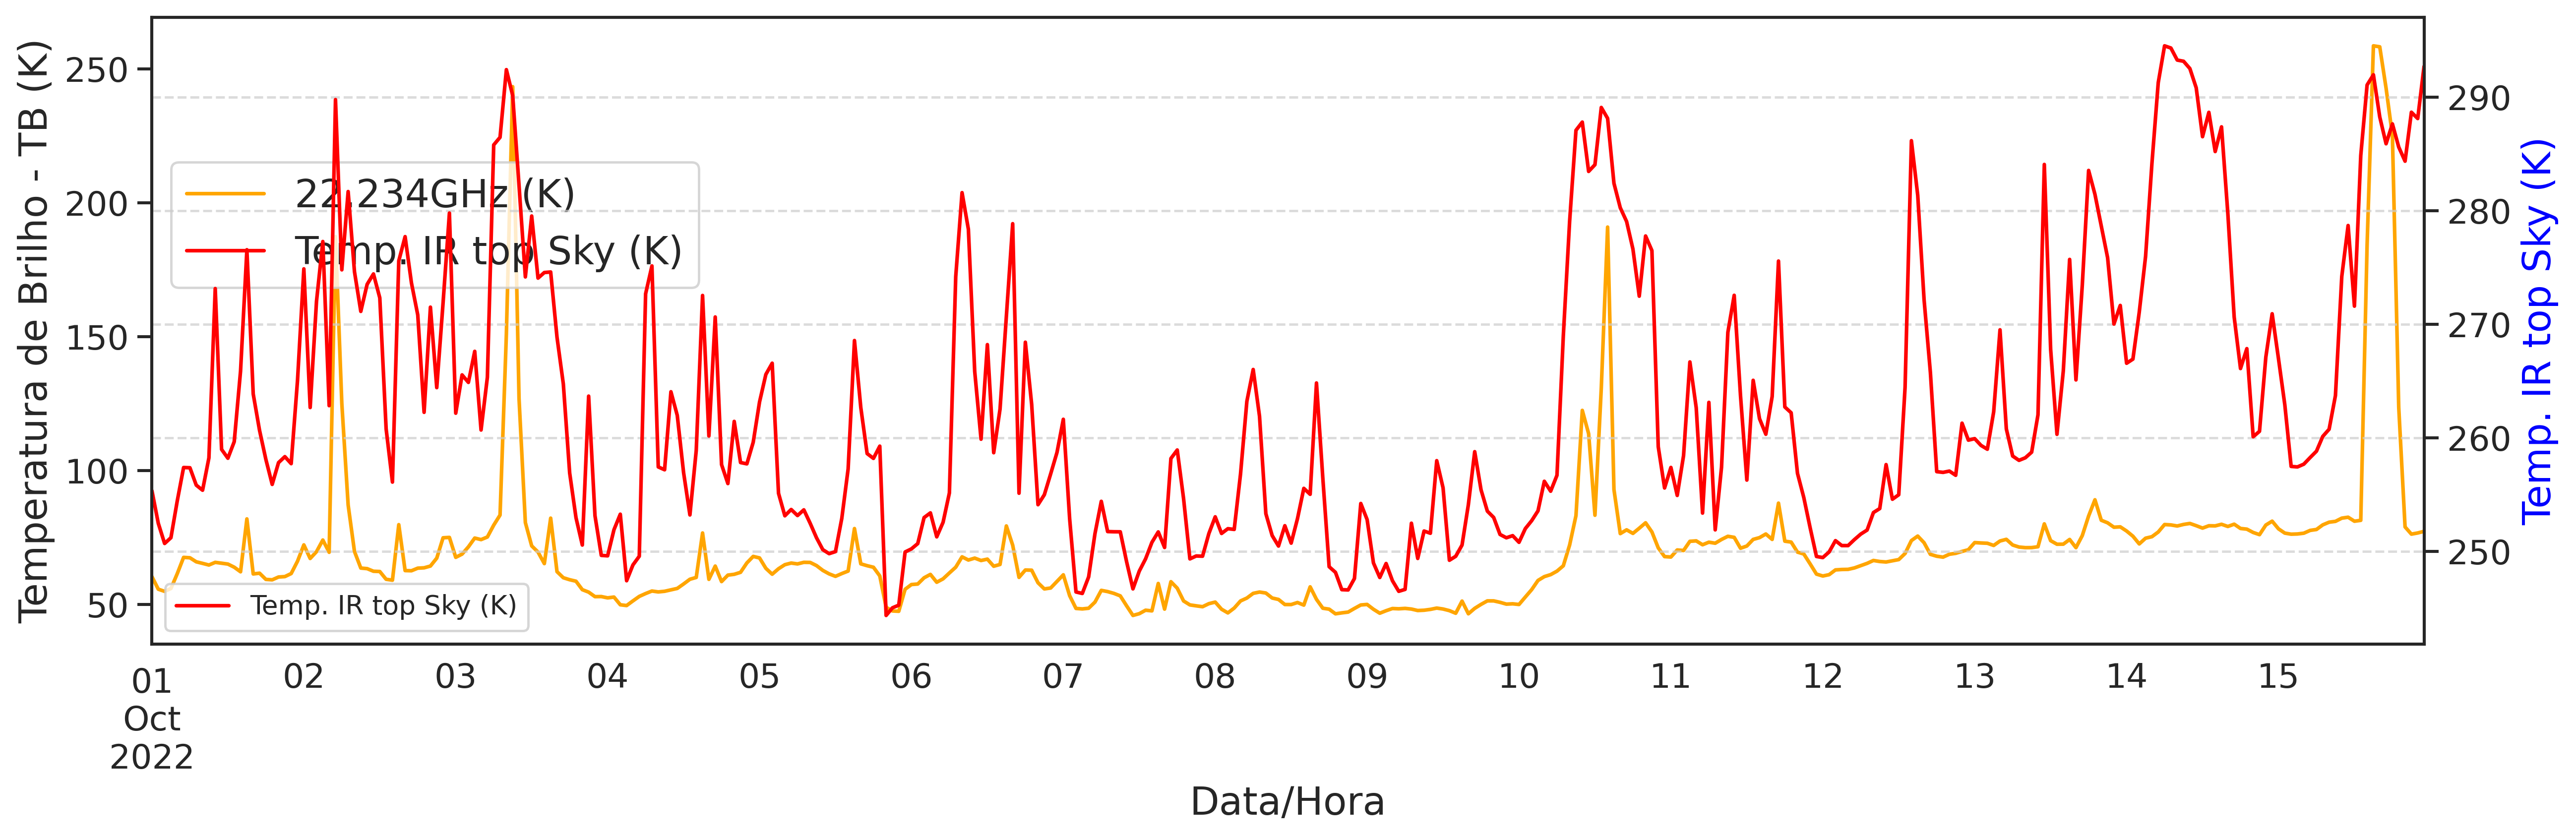

In [20]:
data_inicio = '2022-10-01'
data_final = '2022-10-15'

# Filtrar os dados para o período especificado
df_filtrado = df_complete[data_inicio:data_final]



# Plotar os dados
fig, ax = plt.subplots(figsize=(15, 5), dpi=350)

# Plotar a temperatura de brilho de 22.234GHz, 30.000GHz e 51.248GHz no eixo esquerdo
df_filtrado.plot(kind='line', y="22.234GHz", label='22.234GHz (K)', linestyle='-', color='orange', ax=ax, fontsize=14)
ax.set_ylabel('Temperatura de Brilho - TB (K)', fontsize=16)

# Criar um segundo eixo Y (à direita) para "Rainfall_mmh"
ax2 = ax.twinx()
df_filtrado.plot(kind='line', y="Tir_K", label='Temp. IR top Sky (K)', linestyle='-', color='red', ax=ax2, fontsize=14)
ax2.set_ylabel('Temp. IR top Sky (K)', fontsize=16, color='blue')

ax.set_xlabel('Data/Hora', fontsize=16)

# Manipular as legendas
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.0, 0.8), fontsize=16)

# Grade de fundo
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()


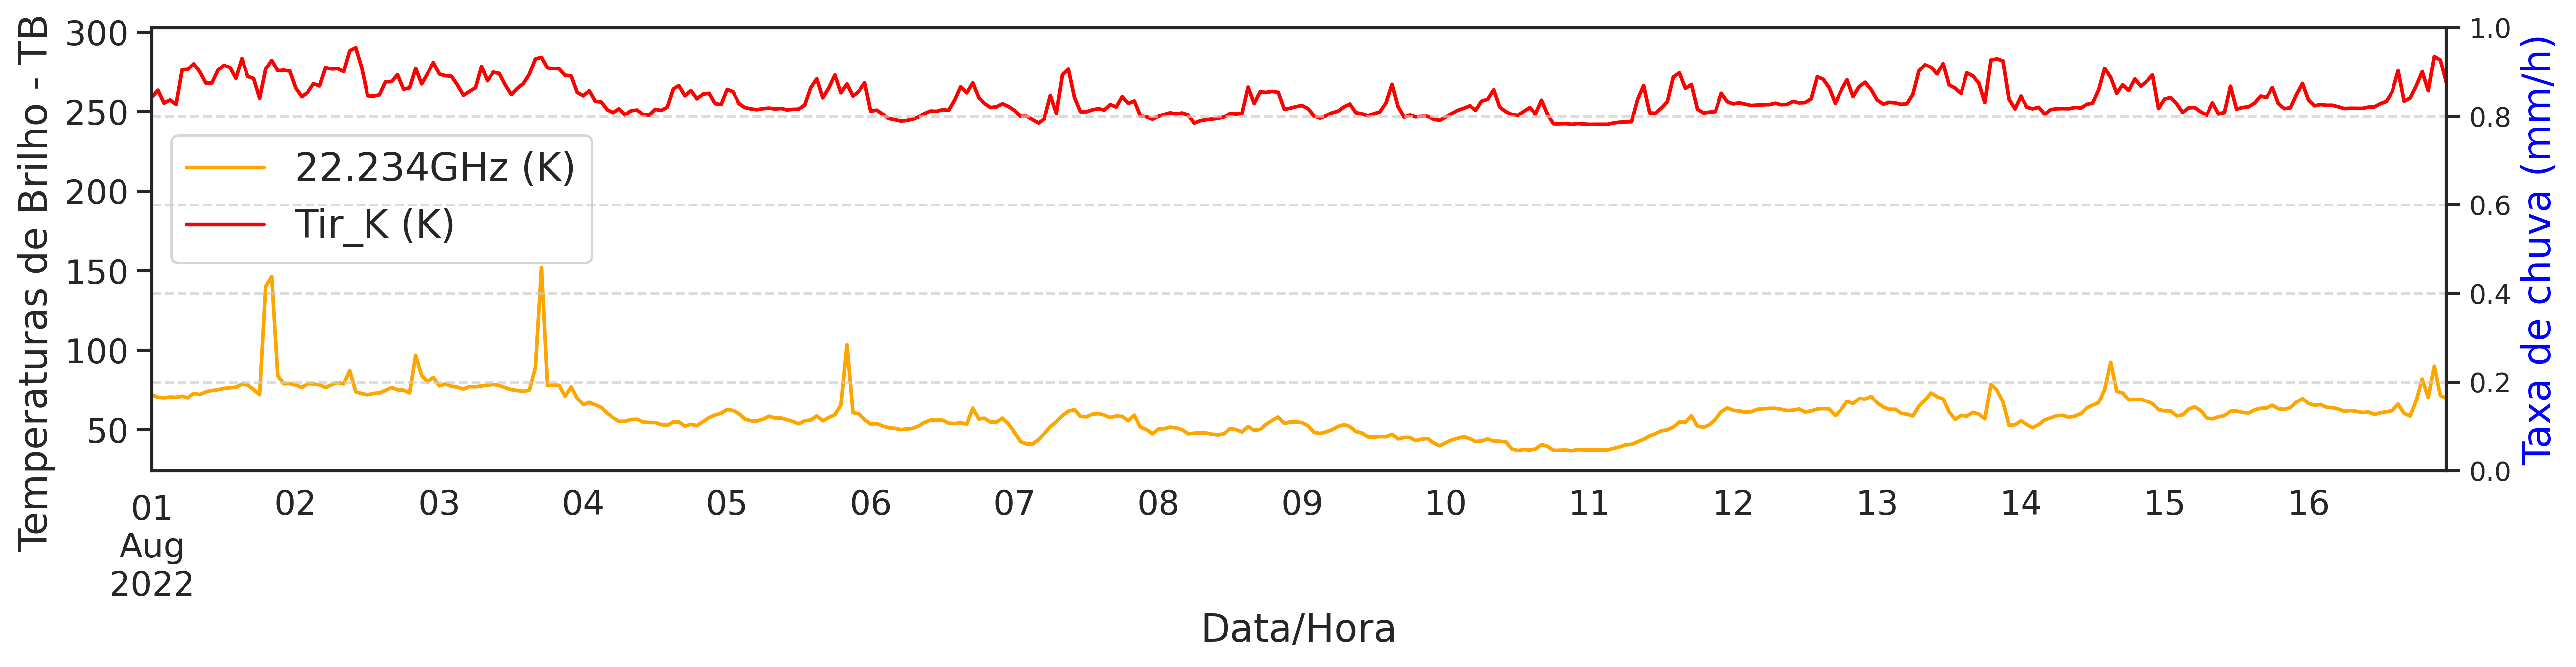

In [21]:
data_inicio = '2022-08-01'
data_final = '2022-08-16'

# Filtrar os dados para o período especificado
df_filtrado = df_complete[data_inicio:data_final]



# Plotar os dados imputados
fig, ax = plt.subplots(figsize=(15, 4), dpi=350)

# Plotar a temperatura de brilho de 22.234GHz, 30.000GHz e 51.248GHz no eixo esquerdo
df_filtrado.plot(kind='line', y="22.234GHz", label='22.234GHz (K)', linestyle='-', color='orange', ax=ax, fontsize=14)
#df_filtrado.plot(kind='line', y="30.000GHz", label='30.000GHz (K)', linestyle='--', color='green', ax=ax, fontsize=14)
df_filtrado.plot(kind='line', y="Tir_K", label='Tir_K (K)', linestyle='-', color='red', ax=ax, fontsize=14)
ax.set_ylabel('Temperaturas de Brilho - TB (K)', fontsize=16)

# Criar um segundo eixo Y (à direita) para "Rainfall_mmh"
ax2 = ax.twinx()
#df_filtrado.plot(kind='line', y="Rainfall_mm_h", label='Taxa de chuva (mm)', linestyle='-', color='blue', ax=ax2, fontsize=14)
ax2.set_ylabel('Taxa de chuva (mm/h)', fontsize=16, color='blue')

ax.set_xlabel('Data/Hora', fontsize=16)

# Manipular as legendas
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.0, 0.8), fontsize=16)

# Grade de fundo
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()


# Definição das **features** a partir das observaçõe nas correlações das variaveis.

### Definição da variável de previsão (**target**)

Primeiramente, vamos preparar os dados para a modelagem, criando uma nova coluna que representa a precipitação uma hora à frente. Essa nova coluna será utilizada como variável de previsão (**target**). Em seguida, filtraremos os dados para focar apenas nos momentos em que há precipitação, e vamos visualizar as primeiras 10 instâncias desses eventos para confirmar se os dados foram deslocados corretamente.

In [ ]:
variables = ['Rainfall_mm_h']
for variable in variables:
    df_final[f'{variable}_t1'] = df_final[variable].shift(-1) #(1h à frente)
df_filter_for_model = df_final.iloc[:-1].copy()

df_filter_for_model[['Rainfall_mm_h', 'Rainfall_mm_h_t1']].loc[((df_filter_for_model['Rainfall_mm_h'] >= 0.1))].head(n=10)


In [ ]:
# Calcular a matriz de correlação diretamente em df_final
correlation_matrix = df_final.corr(method='spearman') #spearman

# Configurar estilo para o gráfico
sns.set(style="white")

# Criar uma máscara para mostrar apenas a metade superior da matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Obter os nomes das variáveis presentes no DataFrame
nomes_variaveis = df_final.columns

# Criar o gráfico de heatmap
plt.figure(figsize=(30, 15), dpi=350)
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Heatmap', fontsize=14)
#plt.ylabel('Variáveis', fontsize=9)
#plt.xlabel('Variáveis', fontsize=9)

# Definir rótulos personalizados para os eixos Y e X com os nomes das variáveis
plt.yticks(np.arange(len(nomes_variaveis)) + 0.5, nomes_variaveis, fontsize=8, va='center')
plt.xticks(np.arange(len(nomes_variaveis)) + 0.5, nomes_variaveis, fontsize=8, rotation=80, ha='center')

plt.show()


### Definição das (**features**)

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# create dataframe for features
X1 = df_filter_for_model.drop(['Rainfall_mm_h_t1'],axis=1) # feature columns
#X1
# create dataframe for target
y1 = df_filter_for_model['Rainfall_mm_h_t1'] # target column
#y1


# Set the default font family to a serif font
plt.rcParams['font.family'] = 'serif'

# Inicialize e ajuste o modelo de regressão linear
model = LinearRegression()
model.fit(X1, y1)

# Obtenha os coeficientes de importância e os nomes das características
importance = model.coef_
feature_names = X1.columns  # Supondo que X1 seja um DataFrame pandas com nomes de colunas

# Imprima o nome da característica e seu coeficiente de importância
for feature_name, coef in zip(feature_names, importance):
    print("Feature:", feature_name, "Score:", coef)

# Plote o gráfico de barras dos coeficientes de importância
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura
plt.bar(feature_names, importance, color='skyblue')  # Adicione cor às barras
plt.xlabel('Features')  # Adicione rótulo ao eixo x
plt.ylabel('Importance Coefficients')  # Adicione rótulo ao eixo y
plt.title('Feature Importance Coefficients')  # Adicione título ao gráfico
plt.xticks(rotation=90)  # Rotacione os rótulos do eixo x para facilitar a leitura
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adicione grades ao eixo y
plt.tight_layout()  # Ajuste o layout para evitar cortes
plt.show()


In [ ]:
X1.columns

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# Plot for df_final
total_T2 = len(df_final)
#axs[0].set_title('Distribuição de Tipos de Chuva (Dataset T2)', fontsize=13)
sns.countplot(x='Class_Rain', data=df_final, palette='viridis', ax=axs[0])
for p in axs[0].patches:
    axs[0].annotate('{:.2f}%'.format(100 * p.get_height() / total_T2), (p.get_x() + 0.2, p.get_height() + 5), fontsize=9)
axs[0].yaxis.set_ticks(np.linspace(0, total_T2, 10))
axs[0].set_yticklabels(map('{:.2f}%'.format, 100 * axs[0].yaxis.get_majorticklocs() / total_T2), fontsize=9)
axs[0].set_xlabel('Tipos de Chuva (Antes)', fontsize=11)
axs[0].set_ylabel('Frequência (%)', fontsize=11)
axs[0].set_xticklabels(['Sem Chuva', 'Chuva Fraca', 'Chuva Moderada', 'Chuva Forte', 'Chuva Muito Forte'], rotation=15, fontsize=7)
axs[0].grid()

# Plot for Dataset_T2_balanced
total_T2_balanced = len(df_final)
#axs[1].set_title('Distribuição de Tipos de Chuva (Dataset T2 Balanceado)', fontsize=13)
sns.countplot(x='Class_Rain', data=df_final, palette='viridis', ax=axs[1])
for p in axs[1].patches:
    axs[1].annotate('{:.2f}%'.format(100 * p.get_height() / total_T2_balanced), (p.get_x() + 0.2, p.get_height() + 5), fontsize=9)
axs[1].yaxis.set_ticks(np.linspace(0, total_T2_balanced, 10))
axs[1].set_yticklabels(map('{:.2f}%'.format, 100 * axs[1].yaxis.get_majorticklocs() / total_T2_balanced), fontsize=9)
axs[1].set_xlabel('Tipos de Chuva (Depois)', fontsize=11)
axs[1].set_ylabel('Frequência (%)', fontsize=11)
axs[1].set_xticklabels(['Sem Chuva', 'Chuva Fraca', 'Chuva Moderada', 'Chuva Forte', 'Chuva Muito Forte'], rotation=15, fontsize=7)
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

df_final['Class_Rain'].value_counts()

In [ ]:
# Selecting the features and the target

features = ['Tamb_k','Tir_K', '22.234GHz', '22.500GHz', '23.034GHz', '23.834GHz', '25.000GHz',
       '26.234GHz', '51.248GHz', '51.760GHz', '52.280GHz', '52.804GHz', '53.336GHz', '54.400GHz',
       '54.940GHz', '55.500GHz', '56.020GHz', '57.288GHz']

target = 'Rainfall_mm_h_t1'

In [ ]:
df_filter_for_model_copy = df_final.copy()

In [ ]:
df_final.index.max()

In [ ]:
# Filtrar os dados para o período especificado para usar separadamente em treino e testes do modelo

data_final = '2023-10-01'
df_final_for_training = df_final[:data_final].copy()

data_inicio = '2023-10-02'
df_for_tests = df_final[data_inicio:].copy()

# **DEFINITIONS - TESTE 1:**

*  **Todos os dados de chuva registrados no período observado**.. Neste caso, chuvas com taxa acumulada igual ou maior que **0.1mm/h**.

**Divisão dos dados em treino. validação e teste.**

In [ ]:
Dataset_T0 = df_final_for_training.loc[((df_final_for_training['Rainfall_mm_h_t1'] >= 0))
].copy()


# Supondo que Dataset_T0 já está definido e contém os dados

# Definir os dados
a = Dataset_T0[features]
b = Dataset_T0[target]

# Definir os pontos de corte
training_percentage = 0.7
total_data_points = len(a)
training_index = int(total_data_points * training_percentage)

# Dividir os dados em conjuntos de treinamento, validação e teste
X_train_0 = a.iloc[:training_index]
y_train_0 = b.iloc[:training_index]

X_validation_test = a.iloc[training_index:]
y_validation_test = b.iloc[training_index:]

# Dividir os dados de validação e teste igualmente (50% cada)
validation_percentage = 0.5
validation_index = int(len(X_validation_test) * validation_percentage)

X_val_0 = X_validation_test.iloc[:validation_index]
y_val_0 = y_validation_test.iloc[:validation_index]

X_test_0 = X_validation_test.iloc[validation_index:]
y_test_0 = y_validation_test.iloc[validation_index:]

# Contar eventos de chuva >= 0.1 em cada conjunto
def count_events(data):
    return (data >= 0.1).sum()

train_events = count_events(y_train_0)
val_events = count_events(y_val_0)
test_events = count_events(y_test_0)

# Imprimir data inicial e final de cada pedaço dos dados
print("Data inicial e final do conjunto de treino:")
print(f"Inicial: {y_train_0.index.min()}, Final: {y_train_0.index.max()}")
print(f"Número de eventos de chuva >= 0.1 mm/h: {train_events}")

print("\nData inicial e final do conjunto de validação:")
print(f"Inicial: {y_val_0.index.min()}, Final: {y_val_0.index.max()}")
print(f"Número de eventos de chuva >= 0.1 mm/h: {val_events}")

print("\nData inicial e final do conjunto de testes:")
print(f"Inicial: {y_test_0.index.min()}, Final: {y_test_0.index.max()}")
print(f"Número de eventos de chuva >= 0.1 mm/h: {test_events}")

# Configurar o estilo do gráfico
plt.rcParams['font.family'] = 'serif'

# Gerar o gráfico
fig, ax = plt.subplots(figsize=(15, 5))
y_train_0.plot(ax=ax, label='Dados de treino')
y_val_0.plot(ax=ax, label='Dados de validação')
y_test_0.plot(ax=ax, label='Dados de testes')
ax.axvline(y_train_0.index.max(), color='black', ls='--')
ax.axvline(y_val_0.index.max(), color='black', ls='--')
ax.legend(['Dados de treino', 'Dados de validação', 'Dados de testes'])
plt.show()




---



# Functions view results metrics MAE, RMSE, POD and FAR**

In [ ]:
def calculate_pod(true_positives, false_negatives):
    if true_positives + false_negatives > 0:
        return true_positives / (true_positives + false_negatives)
    return 0  # Alterado de None para 0

def calculate_far(false_positives, true_negatives):
    if false_positives + true_negatives > 0:
        return false_positives / (false_positives + true_negatives)
    return 0  # Alterado de None para 0

def calculate_skill_score(pod, far):
    # Calcular o Skill Score com base em POD e FAR
    return (pod - far) / (1 - far) if (1 - far) > 0 else 0

def get_dynamic_interpretation(pod, far):
    interpretation = np.select(
        [pod >= 0.8 and far <= 0.2,
         pod >= 0.6 and far <= 0.4,
         pod >= 0.4 and far <= 0.6],
        ["Alta detecção, baixos falsos alarmes.",
         "Boa detecção, moderados falsos alarmes.",
         "Detecção razoável, falsos alarmes significativos."],
        default="Baixa detecção e/ou altos falsos alarmes."
    )
    interpretation[pod is None] = "Interpretação não disponível."
    return interpretation

def evaluate_and_get_results(y_test, y_pred, dataset_name):
    Joss_RI_mmh_classes = {
        "Chuva Fraca": [0.1, 2.5],
        "Chuva Moderada": [2.5, 10],
        "Chuva Forte": [10, 20]
    }

    if dataset_name == "T1":
        Joss_RI_mmh_classes["Chuva Muito Forte"] = [20, float('inf')]

    class_counts = {Joss_RI_mmh_class: [0, 0, 0, 0] for Joss_RI_mmh_class in Joss_RI_mmh_classes}

    for observed, predicted in zip(y_test, y_pred):
        observed_class = None
        predicted_class = None

        for Joss_RI_mmh_class, thresholds in Joss_RI_mmh_classes.items():
            if thresholds[0] <= observed < thresholds[1]:
                observed_class = Joss_RI_mmh_class
                break

        for Joss_RI_mmh_class, thresholds in Joss_RI_mmh_classes.items():
            if thresholds[0] <= predicted < thresholds[1]:
                predicted_class = Joss_RI_mmh_class
                break

        if observed_class is not None and predicted_class is not None:
            class_counts[observed_class][0] += 1
            class_counts[predicted_class][1] += 1

            if observed_class == predicted_class:
                class_counts[observed_class][2] += 1
            else:
                class_counts[observed_class][3] += 1

    results = []
    for Joss_RI_mmh_class, counts in class_counts.items():
        pod = calculate_pod(counts[2], counts[3])
        far = calculate_far(counts[3], counts[2])
        skill_score = calculate_skill_score(pod, far)
        dynamic_interpretation = get_dynamic_interpretation(pod, far)
        results.append([Joss_RI_mmh_class, pod, far, skill_score, dynamic_interpretation])

    total_true_positives = sum(counts[2] for counts in class_counts.values())
    total_false_positives = sum(counts[3] for counts in class_counts.values())
    total_false_negatives = sum(counts[0] for counts in class_counts.values())
    total_true_negatives = sum(counts[1] for counts in class_counts.values())

    total_pod = calculate_pod(total_true_positives, total_false_negatives)
    total_far = calculate_far(total_false_positives, total_true_negatives)
    total_skill_score = calculate_skill_score(total_pod, total_far)

    total_interpretation = get_dynamic_interpretation(total_pod, total_far)
    results.append(['Geral', total_pod, total_far, total_skill_score, total_interpretation])

    return results

def print_results_table(results):
    print(f"{'Rain Class':<25} {'POD':<10} {'FAR':<10} {'Skill Score':<12} {'Interpretação':<40}")
    print("="*90)
    for row in results:
        print(f"{row[0]:<25} {row[1]:<10.2f} {row[2]:<10.2f} {row[3]:<12.2f} {row[4]:<40}")

# MÉTRICAS MAE E RMSE -----------------------------------------------------------
def print_metrics(metrics, dataset_name):
    mae = metrics['MAE'][0]
    rmse = metrics['RMSE'][0]

    print(f'{dataset_name}:')
    print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')


Os pesos das amostras são calculados com base nas frequências das classes no conjunto de dados. Classes menos frequentes recebem pesos mais altos, enquanto classes mais frequentes recebem pesos mais baixos. Isso é feito para equilibrar o impacto das classes durante o treinamento de um modelo, permitindo que ele dê mais atenção às classes minoritárias e, assim, melhorar o desempenho em cenários de desbalanceamento de dados. Essa abordagem ajuda o modelo a fazer previsões mais precisas para todas as classes, independentemente de sua representação no conjunto de dados.

# Other Calculation of sample weights

In [ ]:
import pandas as pd

# Supondo que y_train_0 seja uma Series com os dados de chuva
y_train_2_copy = y_train_0.to_frame(name='Rainfall_mm_h_t1')

# Adicionar a coluna 'Class_Rain' ao DataFrame
y_train_2_copy['Class_Rain'] = 0

for index, row in y_train_2_copy.iterrows():
    if (row['Rainfall_mm_h_t1'] >= 0.1) and (row['Rainfall_mm_h_t1'] < 2.5):
        y_train_2_copy.loc[index, 'Class_Rain'] = 1  # Light rain
    elif (row['Rainfall_mm_h_t1'] >= 2.5) and (row['Rainfall_mm_h_t1'] < 10):
        y_train_2_copy.loc[index, 'Class_Rain'] = 2  # Moderate rain
    elif (row['Rainfall_mm_h_t1'] >= 10) and (row['Rainfall_mm_h_t1'] < 20):
        y_train_2_copy.loc[index, 'Class_Rain'] = 3  # Heavy rain
    elif row['Rainfall_mm_h_t1'] >= 20:
        y_train_2_copy.loc[index, 'Class_Rain'] = 4  # Very Heavy rain
    else:
        y_train_2_copy.loc[index, 'Class_Rain'] = 0  # No rain

# Cálculo dos pesos de amostra
# Identificação das classes e do número de amostras
class_counts = y_train_2_copy['Class_Rain'].value_counts()

# Calcular frequências relativas e pesos para cada classe
class_frequencies = class_counts / len(y_train_2_copy)
class_weights = 1 / class_frequencies

# Impressão dos pesos para cada classe
for class_label, weight in class_weights.items():
    print(f"Peso da Classe {class_label}: {round(weight, 1)}")


# **Model MLP RNA**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalizar os dados
scaler = MinMaxScaler()  # ou StandardScaler()
X_train_0_normalized = scaler.fit_transform(X_train_0)
X_val_0_normalized = scaler.transform(X_val_0)
X_test_0_normalized = scaler.transform(X_test_0)

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, Callback

tf.keras.backend.clear_session()

# Função para calcular pesos das amostras
def calculate_sample_weights(y_train, num_levels=5):
    df = y_train.to_frame(name='Rainfall_mm_h_t1')
    # Classificação de chuva
    df['Class_Rain'] = np.select(
        [
            (df['Rainfall_mm_h_t1'] >= 0.1) & (df['Rainfall_mm_h_t1'] < 2.5),
            (df['Rainfall_mm_h_t1'] >= 2.5) & (df['Rainfall_mm_h_t1'] < 10),
            (df['Rainfall_mm_h_t1'] >= 10) & (df['Rainfall_mm_h_t1'] < 20),
            (df['Rainfall_mm_h_t1'] >= 20)
        ],
        [1, 2, 3, 4],
        default=0
    )

    # Contagem e cálculo dos pesos
    sample_counts = df['Class_Rain'].value_counts().sort_index()
    total_samples = len(df)
    sample_weights = total_samples / (num_levels * sample_counts)

    return sample_weights

# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'MAE': [mae], 'RMSE': [rmse]}

# Função para treinar e prever com o modelo
def train_and_predict_model(X_train, Y_train, x_val, y_val, X_test, y_test, dataset_name):
    if dataset_name == 'T0':
        # Calculando os pesos das amostras
        sample_weights = np.ones_like(Y_train)
        weights = calculate_sample_weights(Y_train)

        # Definindo os pesos com base nas classes de chuva
        sample_weights[Y_train >= 20] = weights[4]*1.2
        sample_weights[(Y_train >= 10) & (Y_train < 20)] = weights[3]*1.2
        sample_weights[(Y_train >= 2.5) & (Y_train < 10)] = weights[2]
        sample_weights[(Y_train >= 0.1) & (Y_train < 2.5)] = weights[1]
        #sample_weights[Y_train < 0.1] = weights[0]

        #print("Sample weights:")
        #print(sample_weights)

    # Configurar o modelo
    tf.keras.backend.clear_session()
    model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Camada de entrada explícita
        Dense(neuron_input, activation='linear', kernel_regularizer=regularizers.l2(REGULARIZER)),
        Dropout(DROPOUT_MODEL_i),
        Dense(100, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER)),
        Dropout(DROPOUT_MODEL_ii),
        Dense(100, activation='relu', kernel_regularizer=regularizers.l2(REGULARIZER)),
        #Dropout(DROPOUT_MODEL_iii),
        Dense(1, activation='linear')
    ])

    model.compile(
        # mean_absolute_error mean_squared_error
        loss='mean_absolute_error',
        optimizer='adam',
        metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=patience_early_stop, restore_best_weights=True)

    class PrintProgressAtInterval(Callback):
        def __init__(self, interval):
            super(PrintProgressAtInterval, self).__init__()
            self.interval = interval

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.interval == 0:
                print(f'Epoch {epoch+1}/{self.params["epochs"]} - {dataset_name}: MAE: {logs["mae"]:.4f}, Val MAE: {logs["val_mae"]:.4f}, LOSS: {logs["loss"]:.4f}, Val LOSS: {logs["val_loss"]:.4f}')

    print_progress = PrintProgressAtInterval(interval=1)

    # Treinamento do modelo
    history = model.fit(
        X_train, Y_train, validation_data=(x_val, y_val),
        epochs=EPOCHS_MODEL, batch_size=batch_size_val,
        sample_weight=sample_weights if dataset_name == 'T3' else None,
        callbacks=[early_stop, print_progress], verbose=0
    )

    # Alterar para salvar no formato Keras
    model.save(f'Model_{dataset_name}.keras')
    model.summary()

    # Predição com o modelo treinado
    y_pred = model.predict(X_test)
    y_pred_val = model.predict(x_val)

    metrics = calculate_metrics(y_test, y_pred)
    metrics_val = calculate_metrics(y_val, y_pred_val)

    print(f'TREINO CONCLUÍDO PARA O TESTE {dataset_name}\n')
    return history, y_pred, y_pred_val, metrics, metrics_val

# Definir hiperparâmetros
neuron_input = len(features)

EPOCHS_MODEL = 5000
DROPOUT_MODEL_i = 0.5
DROPOUT_MODEL_ii = 0.8
DROPOUT_MODEL_iii = 0.01

REGULARIZER = 0.045
#DROPOUT_MODEL_i = 0.188
#DROPOUT_MODEL_ii = 0.368
#DROPOUT_MODEL_iii = 0.368
#REGULARIZER = 0.0798
batch_size_val = 64
patience_early_stop = 25



# Treino e previsão para os diferentes conjuntos de dados
history_T0, y_pred_T0, y_pred_val_T0, metrics_T0, metrics_val_T0 = train_and_predict_model(
    X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0, 'T0'
)


#IMPRIME AS MÉTRICAS  MAE E RMSE DOS TESTES

print('VALIDAÇÃO - MÉTRICAS  MAE E RMSE')
print_metrics(metrics_val_T0, 'T1')
print('\nTESTE - MÉTRICAS  MAE E RMSE')
print_metrics(metrics_T0, 'T1')

print('\nCoeficiente de Determinação (R²) T1:', round(r2_score(y_test_0, y_pred_T0),3))


print('\nRESULTADOS DOS PARÂMETROS ESTATÍSTICOS "POD" E "FAR" e SKILL SCORE')
# IMPRIME POD E FAR DOS TESTES---------------------------------------------------------
# Avaliar e imprimir resultados para T0
# Calculate results for each scenario
results_T0 = evaluate_and_get_results(y_test_0, y_pred_T0, 'T1')


print("T1:")
print_results_table(results_T0)


Epoch 1/5000 - T0: MAE: 65.9839, Val MAE: 18.4105, LOSS: 127.8365, Val LOSS: 23.1901
Epoch 2/5000 - T0: MAE: 15.1126, Val MAE: 2.9283, LOSS: 37.3657, Val LOSS: 7.5421
Epoch 3/5000 - T0: MAE: 6.4687, Val MAE: 1.9263, LOSS: 22.9091, Val LOSS: 6.3986
Epoch 4/5000 - T0: MAE: 4.5855, Val MAE: 1.8465, LOSS: 20.2520, Val LOSS: 6.1972
Epoch 5/5000 - T0: MAE: 3.4363, Val MAE: 1.6452, LOSS: 17.5890, Val LOSS: 5.8767
Epoch 6/5000 - T0: MAE: 3.0853, Val MAE: 1.8194, LOSS: 16.8047, Val LOSS: 5.9358
Epoch 7/5000 - T0: MAE: 2.4517, Val MAE: 2.0090, LOSS: 16.2859, Val LOSS: 6.0170
Epoch 8/5000 - T0: MAE: 2.5654, Val MAE: 1.0723, LOSS: 15.4516, Val LOSS: 4.9817
Epoch 9/5000 - T0: MAE: 1.9641, Val MAE: 0.8878, LOSS: 14.8494, Val LOSS: 4.6978
Epoch 10/5000 - T0: MAE: 1.9841, Val MAE: 0.7905, LOSS: 14.7574, Val LOSS: 4.5031
Epoch 11/5000 - T0: MAE: 1.8601, Val MAE: 1.0915, LOSS: 14.7945, Val LOSS: 4.7042
Epoch 12/5000 - T0: MAE: 1.6463, Val MAE: 0.7465, LOSS: 14.6029, Val LOSS: 4.2616
Epoch 13/5000 - T0: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 18)                  │             342 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           1,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,031 (86.06 KB)

 Trainable params: 7,343 (28.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,688 (57.38 KB)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TREINO CONCLUÍDO PARA O TESTE T0

VALIDAÇÃO - MÉTRICAS  MAE E RMSE
T1:
MAE: 0.62, RMSE: 2.19

TESTE - MÉTRICAS  MAE E RMSE
T1:
MAE: 0.25, RMSE: 1.29

Coeficiente de Determinação (R²) T1: -0.039

RESULTADOS DOS PARÂMETROS ESTATÍSTICOS "POD" E "FAR" e SKILL SCORE
T1:
Rain Class                POD        FAR        Skill Score  Interpretação                           
Chuva Fraca               0.66       0.34       0.48         Boa detecção, moderados falsos alarmes. 
Chuva Moderada            0.29       0.71       -1.50        Baixa detecção e/ou altos falsos alarmes.
Chuva Forte               0.00       1.00       0.00         Baixa detecção e/ou altos falsos alarmes.
Chuva Muito Forte         0.00       0.00       0.00         Baixa detecção e/ou altos falsos alarmes.
Geral                     0.34       0.32       0.03         Baixa detecção e/ou altos falsos alarmes.


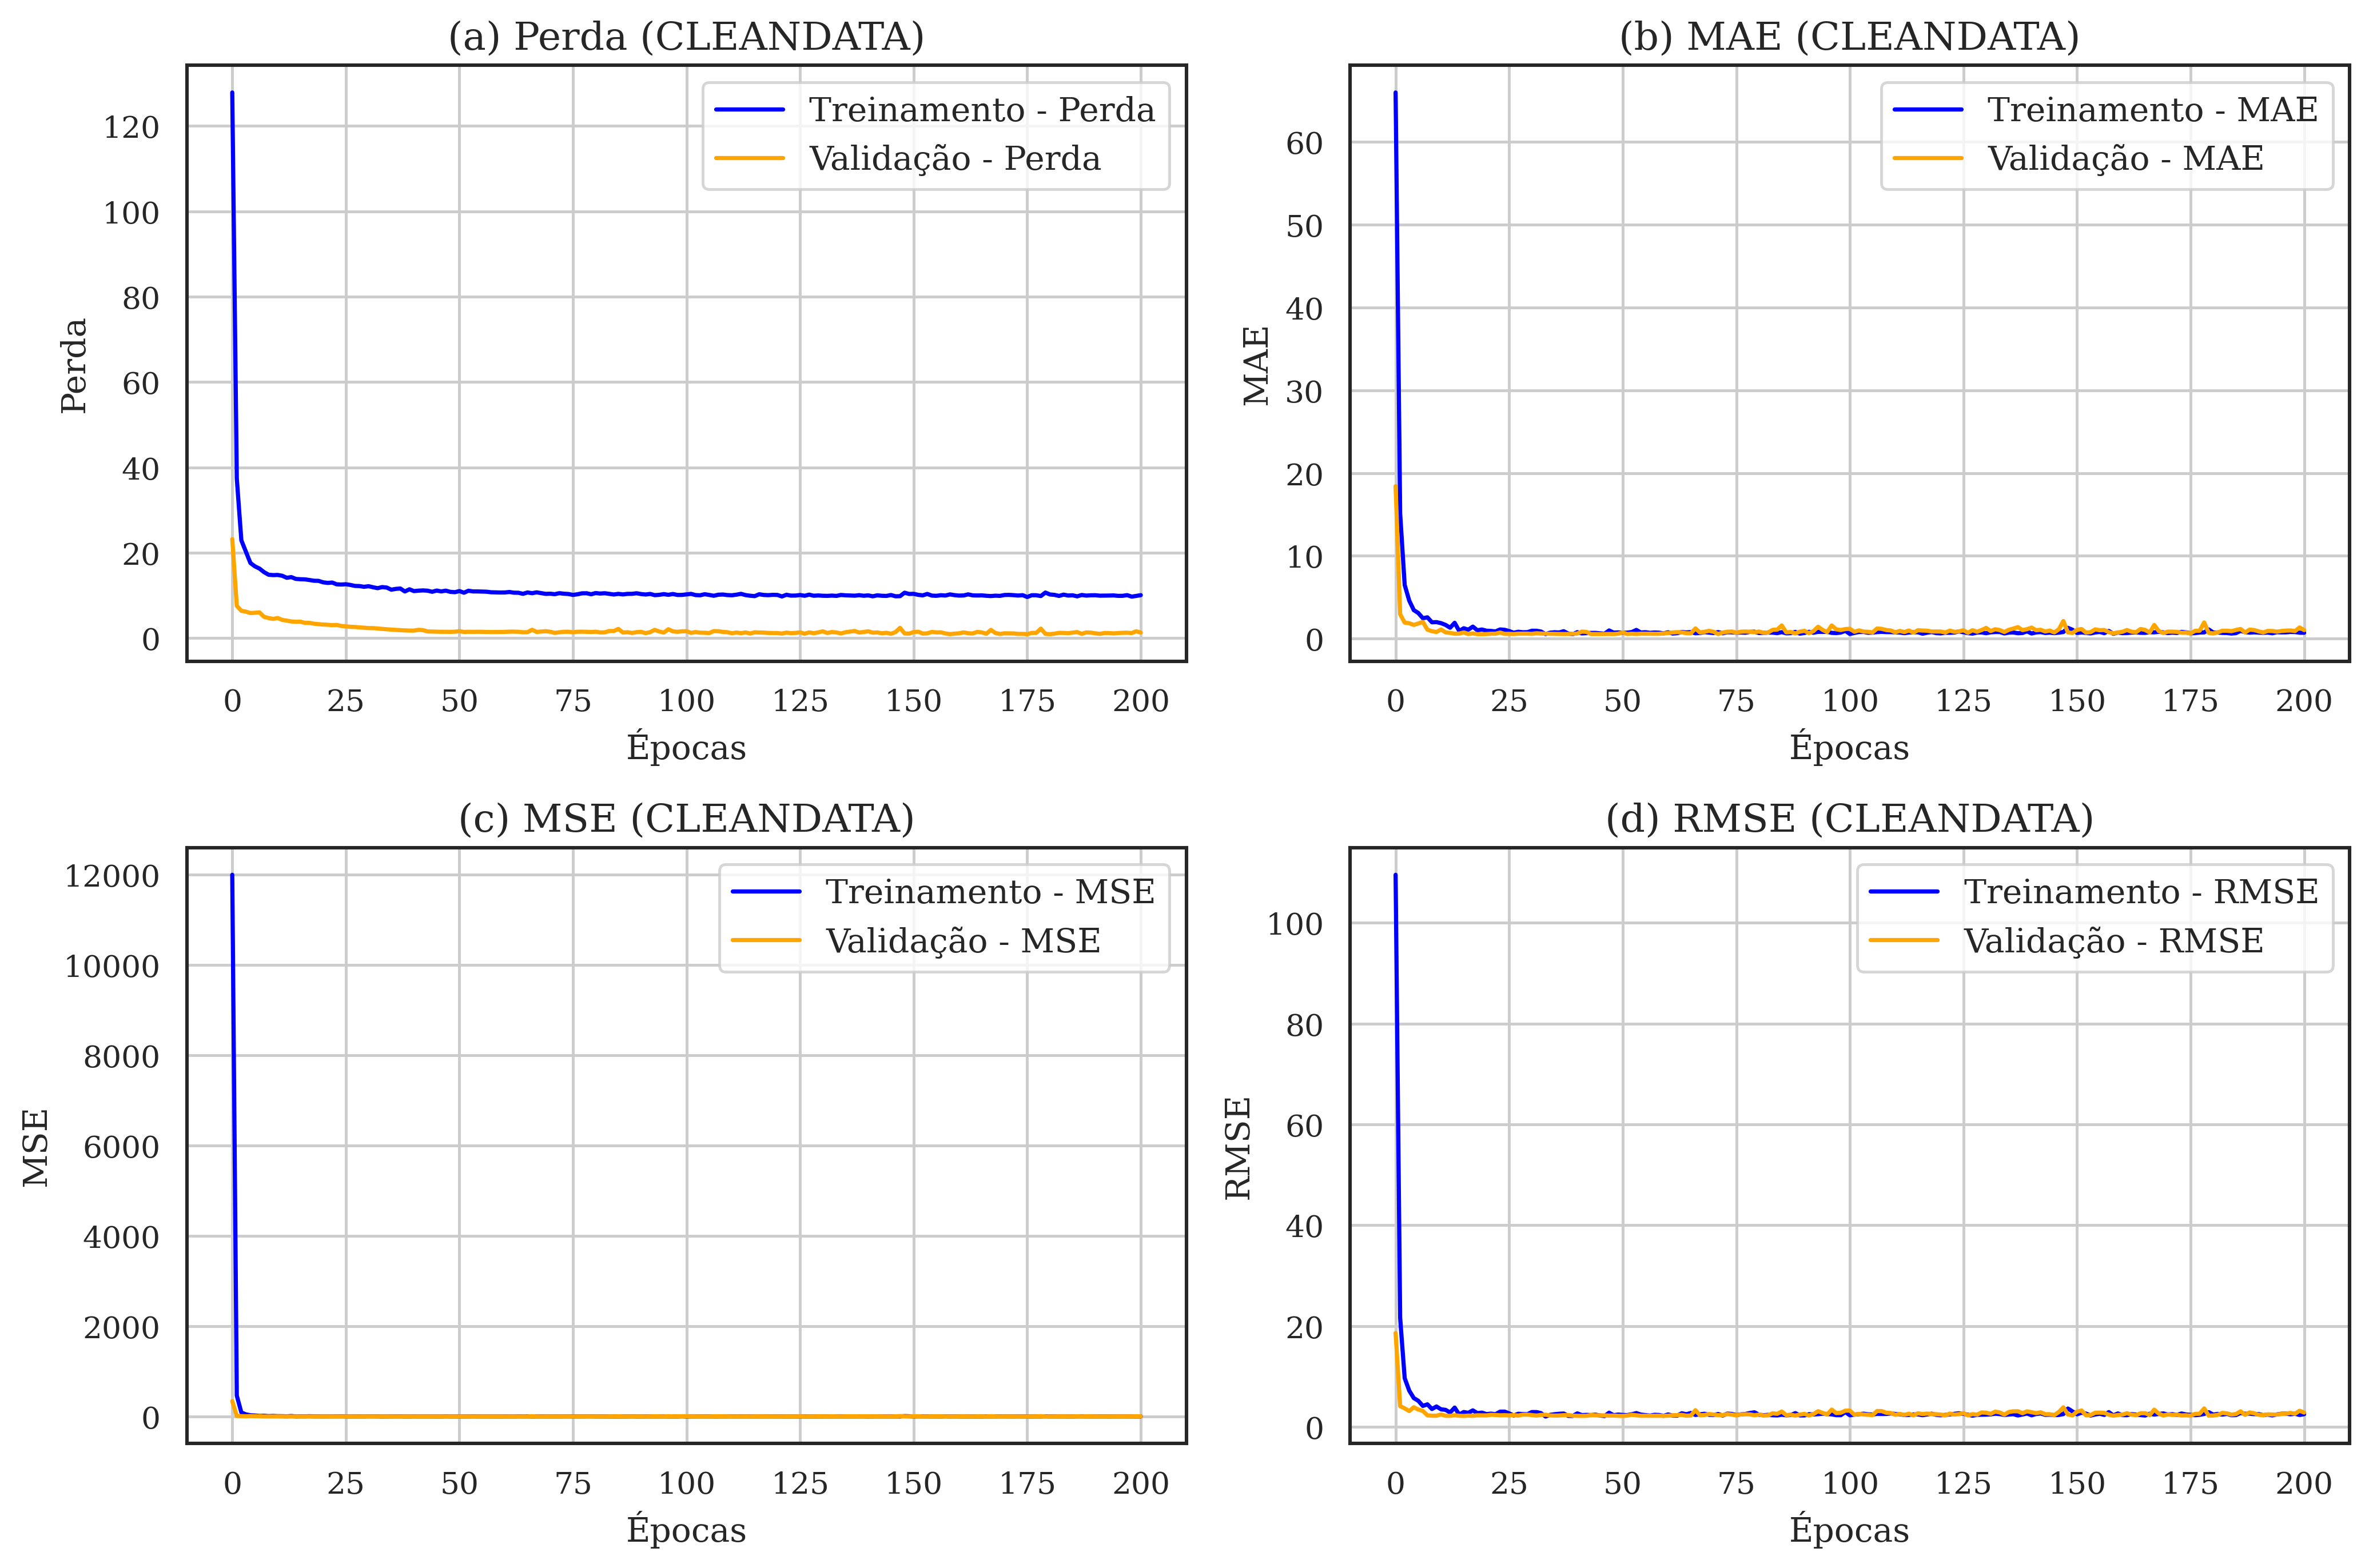

In [68]:
import matplotlib.pyplot as plt

# Definir a fonte padrão para uma fonte serif
plt.rcParams['font.family'] = 'serif'

# Criar uma figura com duas linhas e duas colunas
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=350)  # 2x2 grid

# Conjunto T0 - Perda (primeiro gráfico)
axs[0, 0].plot(history_T0.history['loss'], label='Treinamento - Perda', linestyle='-', color='blue')
axs[0, 0].plot(history_T0.history['val_loss'], label='Validação - Perda', linestyle='-', color='orange')
axs[0, 0].set_ylabel('Perda', fontdict={'fontsize': 12})
axs[0, 0].set_xlabel('Épocas', fontdict={'fontsize': 12})
axs[0, 0].legend(loc='upper right', fontsize=12)
axs[0, 0].grid()
axs[0, 0].set_title('(a) Perda (CLEANDATA)', fontdict={'fontsize': 14})

# Conjunto T0 - MAE
axs[0, 1].plot(history_T0.history['mae'], label='Treinamento - MAE', linestyle='-', color='blue')
axs[0, 1].plot(history_T0.history['val_mae'], label='Validação - MAE', linestyle='-', color='orange')
axs[0, 1].set_ylabel('MAE', fontdict={'fontsize': 12})
axs[0, 1].set_xlabel('Épocas', fontdict={'fontsize': 12})
axs[0, 1].legend(loc='upper right', fontsize=12)
axs[0, 1].grid()
axs[0, 1].set_title('(b) MAE (CLEANDATA)', fontdict={'fontsize': 14})

# Conjunto T0 - MSE
axs[1, 0].plot(history_T0.history['mse'], label='Treinamento - MSE', linestyle='-', color='blue')
axs[1, 0].plot(history_T0.history['val_mse'], label='Validação - MSE', linestyle='-', color='orange')
axs[1, 0].set_ylabel('MSE', fontdict={'fontsize': 12})
axs[1, 0].set_xlabel('Épocas', fontdict={'fontsize': 12})
axs[1, 0].legend(loc='upper right', fontsize=12)
axs[1, 0].grid()
axs[1, 0].set_title('(c) MSE (CLEANDATA)', fontdict={'fontsize': 14})

# Conjunto T0 - RMSE
axs[1, 1].plot(history_T0.history['rmse'], label='Treinamento - RMSE', linestyle='-', color='blue')
axs[1, 1].plot(history_T0.history['val_rmse'], label='Validação - RMSE', linestyle='-', color='orange')
axs[1, 1].set_ylabel('RMSE', fontdict={'fontsize': 12})
axs[1, 1].set_xlabel('Épocas', fontdict={'fontsize': 12})
axs[1, 1].legend(loc='upper right', fontsize=12)
axs[1, 1].grid()
axs[1, 1].set_title('(d) RMSE (CLEANDATA)', fontdict={'fontsize': 14})

# Ajustar o layout e exibir os gráficos
plt.tight_layout()
plt.show()


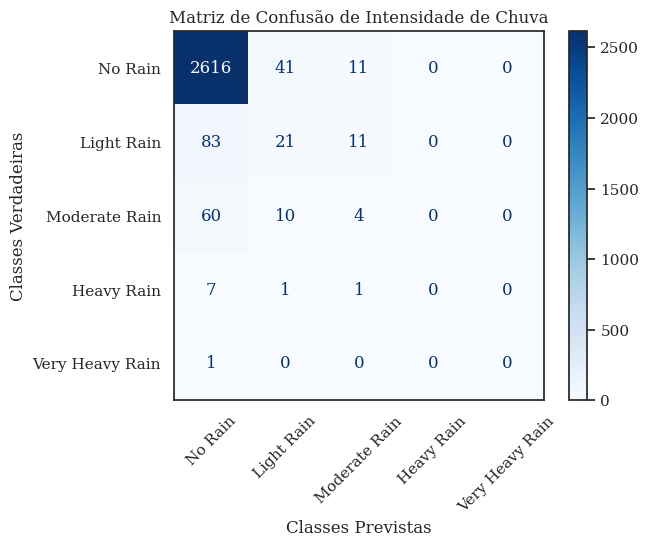

Acurácia: 0.9211719567492153
Precisão: 0.8951683839692774
Revocação: 0.9211719567492153
F1 Score: 0.9068370162351985

Relatório de Classificação:
                  precision    recall  f1-score   support

        No Rain       0.95      0.98      0.96      2668
     Light Rain       0.29      0.18      0.22       115
  Moderate Rain       0.15      0.05      0.08        74
     Heavy Rain       0.00      0.00      0.00         9
Very Heavy Rain       0.00      0.00      0.00         1

       accuracy                           0.92      2867
      macro avg       0.28      0.24      0.25      2867
   weighted avg       0.90      0.92      0.91      2867



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report


# Defina o número de amostras
samples = 140

# Limite o número de amostras
y_test_subset = y_test_0[:].values.flatten()
y_pred_subset = y_pred_T0[:].flatten()

# Função para classificar as intensidades de chuva
def classify_rainfall(rainfall):
    if 0.1 <= rainfall < 2.5:
        return 1  # Light rain
    elif 2.5 <= rainfall < 10:
        return 2  # Moderate rain
    elif 10 <= rainfall < 20:
        return 3  # Heavy rain
    elif rainfall >= 20:
        return 4  # Very Heavy rain
    else:
        return 0  # No rain

# Converter numpy arrays para pandas Series, se necessário
y_test_series = pd.Series(y_test_subset)
y_pred_series = pd.Series(y_pred_subset)

# Aplicar a classificação aos valores de teste e previstos
y_test_classes = y_test_series.apply(classify_rainfall)
y_pred_classes = y_pred_series.apply(classify_rainfall)


# Supondo que y_test_classes e y_pred_classes já foram calculados

# Criar a matriz de confusão
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=[0, 1, 2, 3, 4])

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain', 'Very Heavy Rain'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title('Matriz de Confusão de Intensidade de Chuva')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes Verdadeiras')
plt.show()

# Calcular as métricas
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Imprimir o relatório de classificação
report = classification_report(y_test_classes, y_pred_classes, target_names=['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain', 'Very Heavy Rain'])

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("F1 Score:", f1)
print("\nRelatório de Classificação:\n", report)



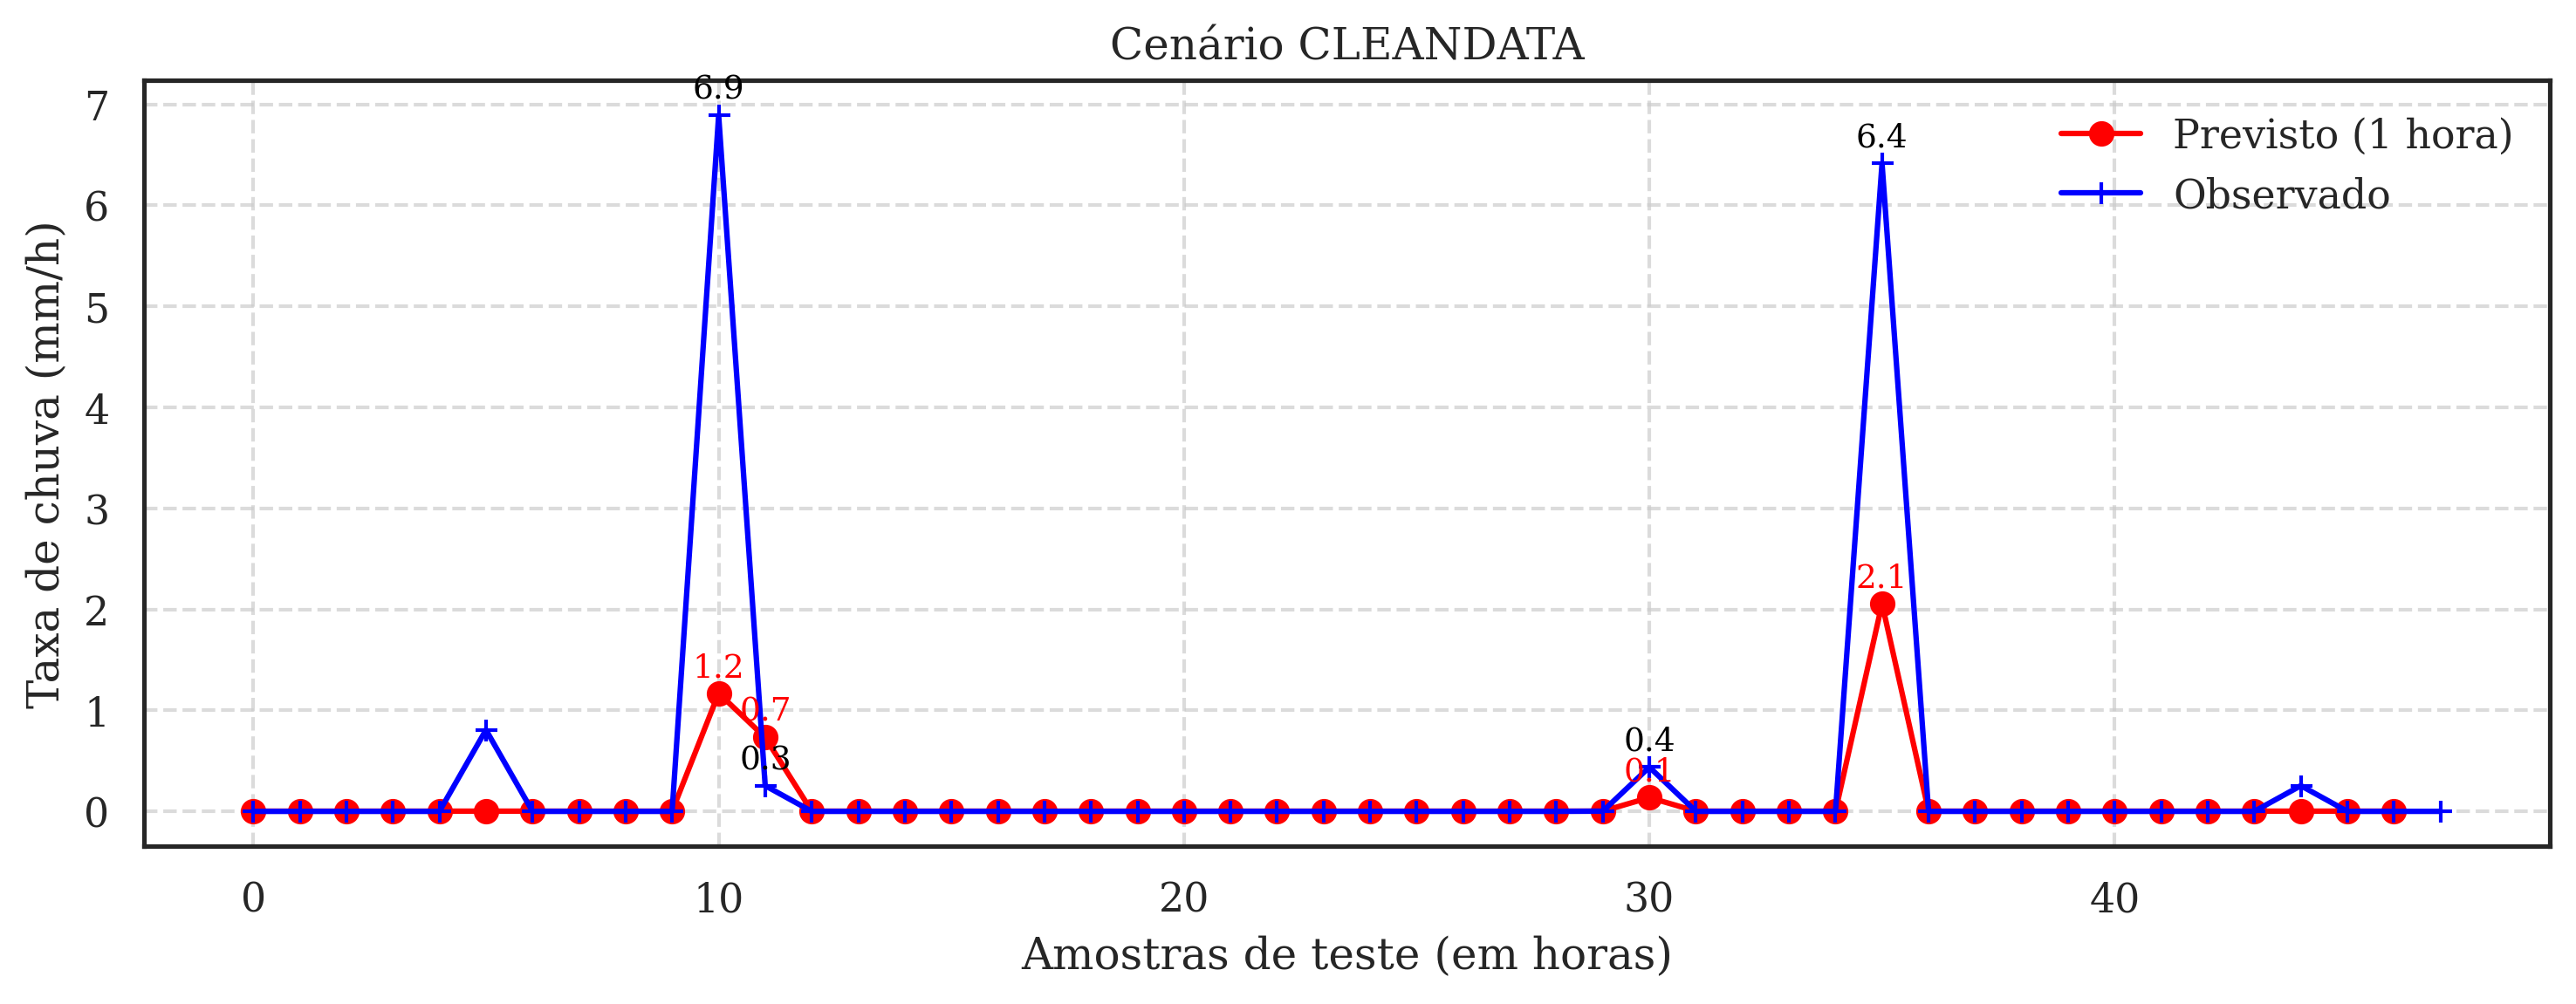

    Observed  Predicted
0   0.000000   0.002041
1   0.000000   0.002041
2   0.000000   0.002041
3   0.000000   0.002041
4   0.000000   0.002041
5   0.806376   0.002041
6   0.000000   0.002041
7   0.000000   0.002041
8   0.000000   0.002041
9   0.000000   0.002041
10  6.889664   1.169379
11  0.254000   0.731297
12  0.000000   0.002041
13  0.000000   0.002041
14  0.000000   0.002041
15  0.000000   0.002041
16  0.000000   0.002041
17  0.000000   0.002041
18  0.000000   0.002041
19  0.000000   0.002041
20  0.000000   0.002041
21  0.000000   0.002041
22  0.000000   0.002041
23  0.000000   0.002041
24  0.000000   0.002041
25  0.000000   0.002041
26  0.000000   0.002041
27  0.000000   0.002041
28  0.000000   0.002041
29  0.002015   0.002041
30  0.437407   0.136536
31  0.000000   0.002041
32  0.000000   0.002041
33  0.000000   0.002041
34  0.000000   0.002041
35  6.414705   2.056002
36  0.000000   0.002041
37  0.000000   0.002041
38  0.000000   0.002041
39  0.000000   0.002041
40  0.000000   0

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Defina o número de amostras
samples = 140

# Limite o número de amostras
y_test_subset = y_test_0[samples:samples+48]
y_pred_subset = y_pred_T0[samples:samples+48]

# Crie um DataFrame com os dados observados e previstos
df = pd.DataFrame({
    "Observed": y_test_subset.values.flatten(),
    "Predicted": y_pred_subset.flatten()  # Inicialmente, defina como NaN para depois preencher corretamente
})

# Adicione o deslocamento para as previsões (1 hora à frente)
df["Predicted"] = df["Predicted"].shift(-1)  # Desloca os valores observados para o horário da previsão

# Crie a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

# Adicione o subplot para o gráfico de linhas
ax.plot(df.index, df["Predicted"], linestyle='-', marker='o', color='red', label='Previsto (1 hora)')
ax.plot(df.index, df["Observed"], linestyle='-', marker='+', color='blue', label='Observado')

# Adicione rótulos e título
ax.set_xlabel('Amostras de teste (em horas)', fontsize=12)
ax.set_ylabel('Taxa de chuva (mm/h)', fontsize=12)
ax.set_title('Cenário CLEANDATA', fontsize=12)

# Ajuste a legenda e a grade
ax.legend(frameon=False)  # Remove a borda da legenda
ax.grid(True, linestyle='--', alpha=0.7)

# Adicionar valores acima dos pontos apenas se a previsão for maior ou igual a 0.1
for i, (pred_val, obs_val) in enumerate(zip(df["Predicted"].dropna(), df["Observed"].dropna())):
    if pred_val >= 0.1:
        ax.text(df.index[i], pred_val + 0.1, f'{round(pred_val, 1)}', ha='center', va='bottom', color='red', fontsize=9)
        ax.text(df.index[i], obs_val + 0.1, f'{round(obs_val, 1)}', ha='center', va='bottom', color='black', fontsize=9)


plt.tight_layout()
plt.show()

print(df)


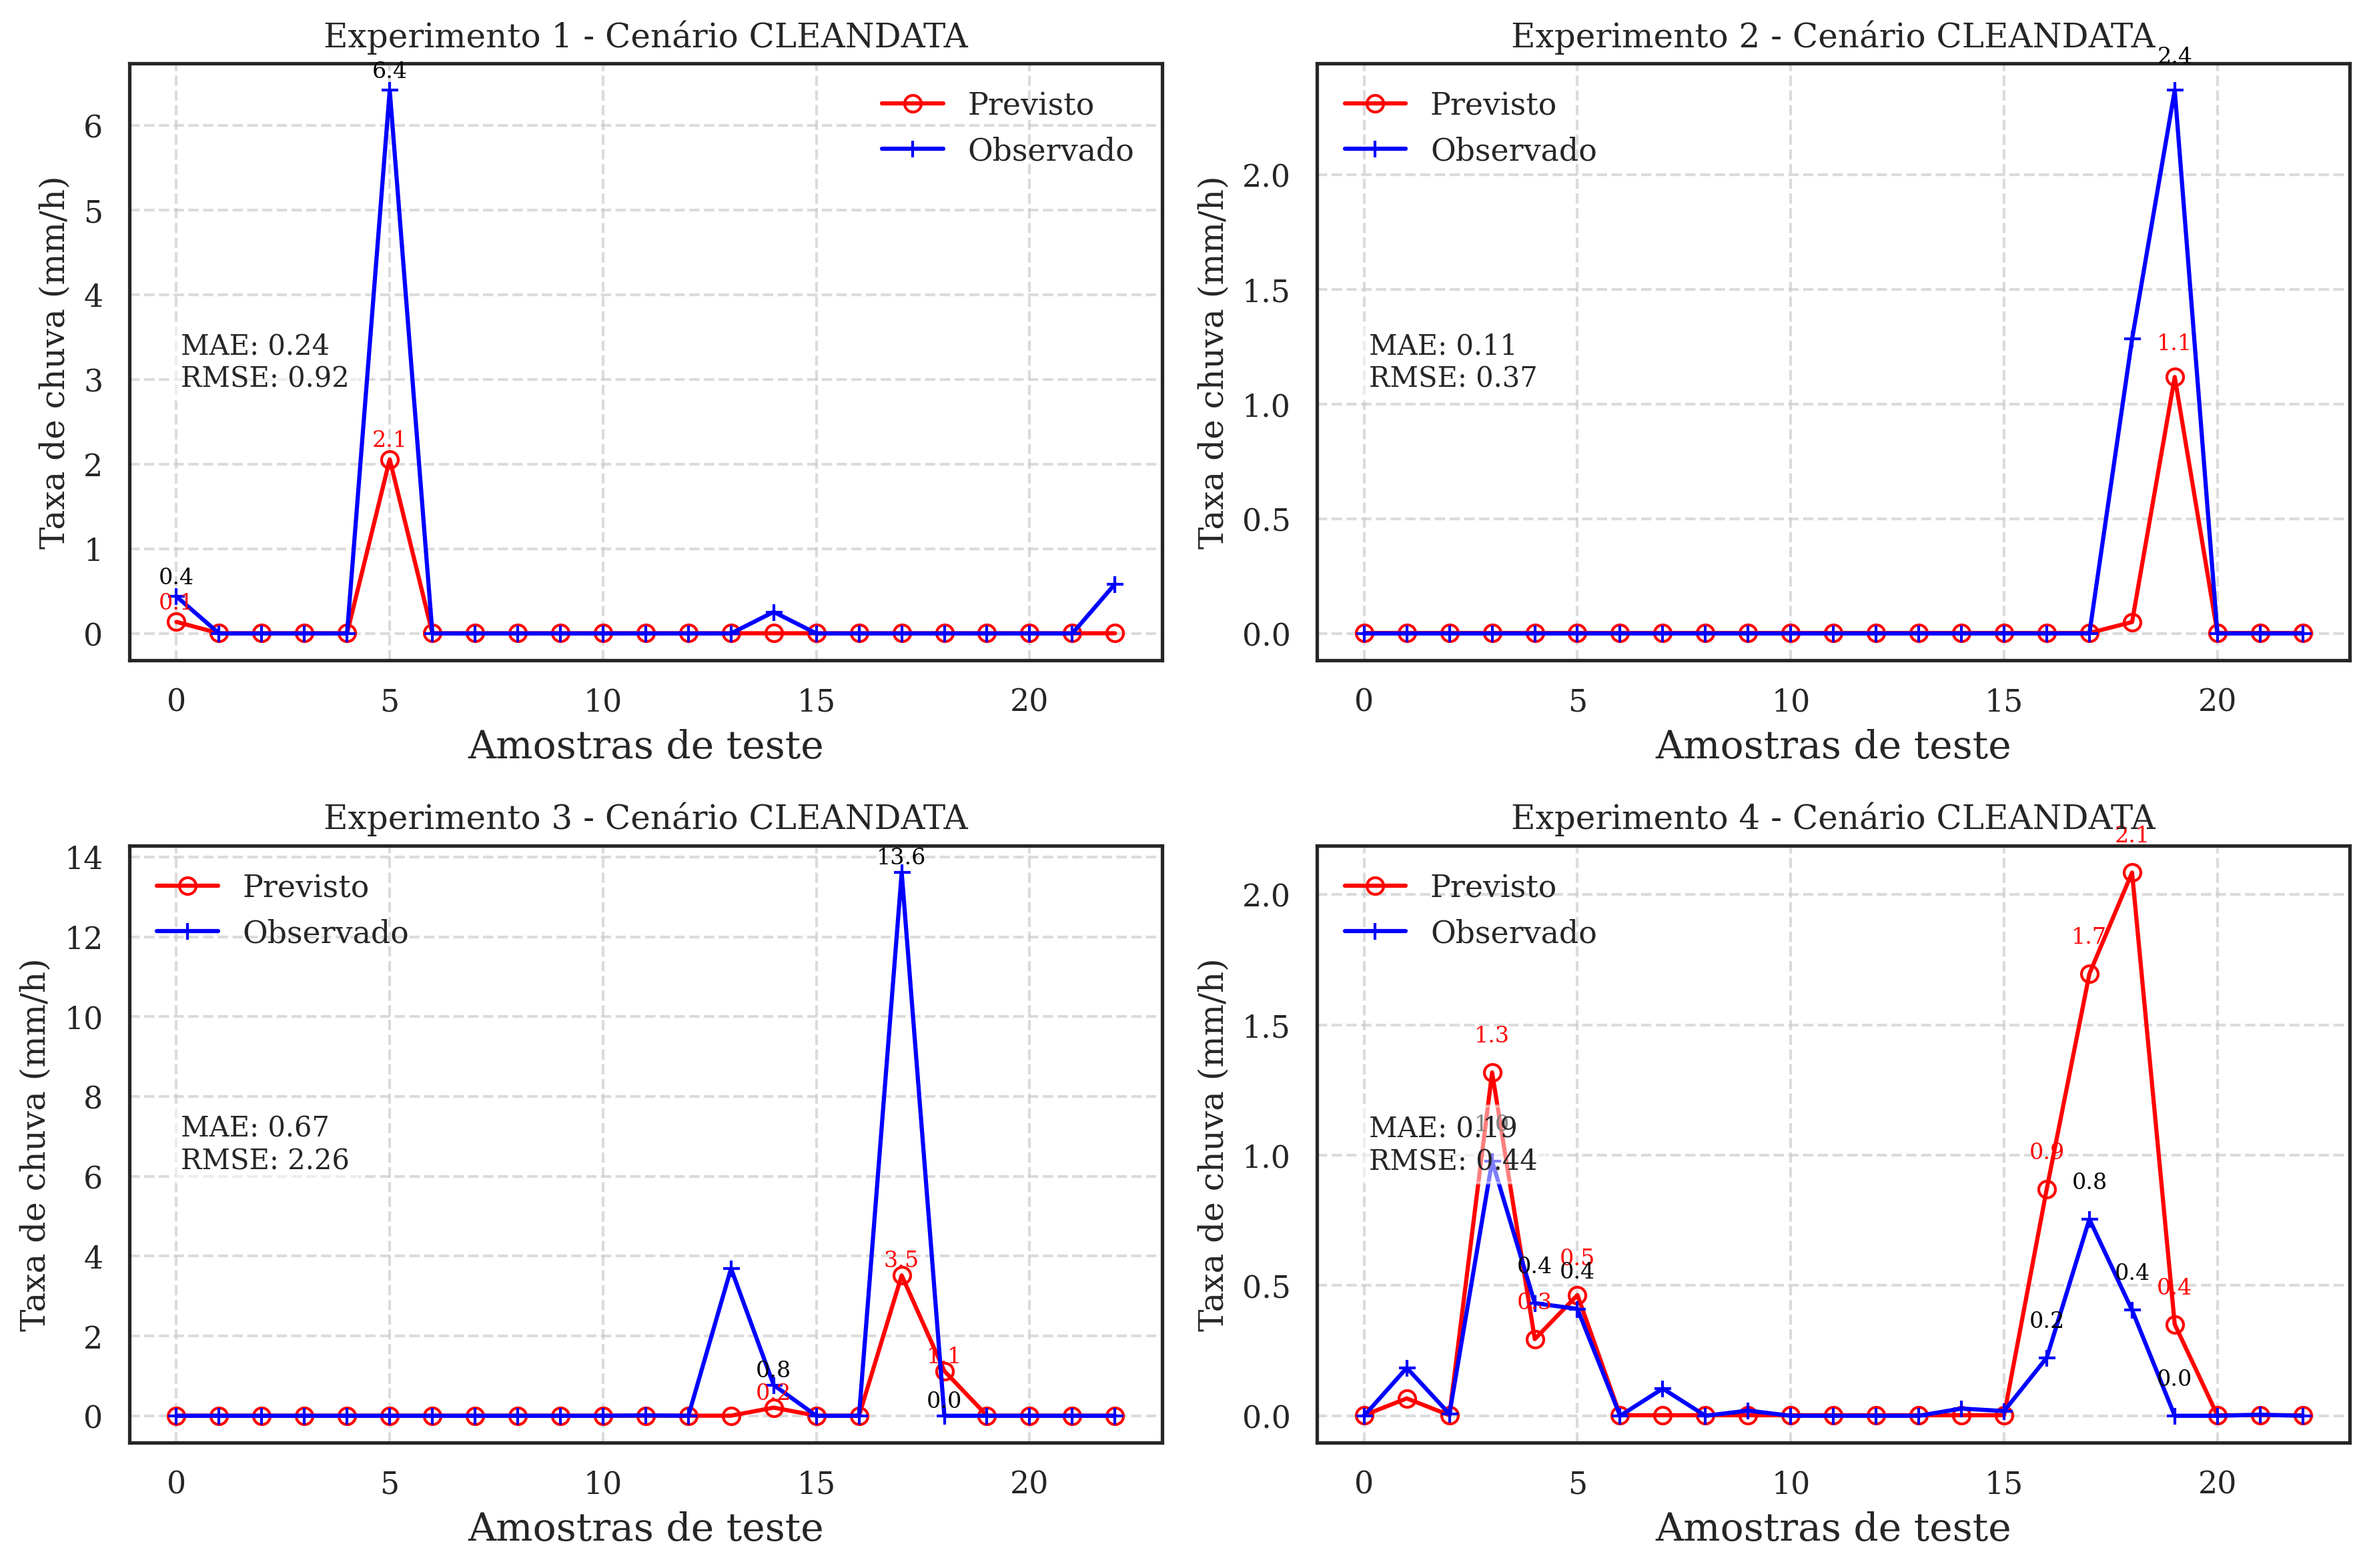

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Defina o número de amostras para cada experimento
sample_indices = [170, 200, 230, 260]

# Crie a figura e os eixos 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=300)

# Itere sobre cada subplot e conjunto de amostras
for idx, ax in enumerate(axs.flat):
    samples = sample_indices[idx]

    # Limite o número de amostras para cada subplot
    y_test_subset = y_test_0[samples:samples+24]
    y_pred_subset = y_pred_T0[samples:samples+24]

    # Crie um DataFrame com os dados observados e previstos
    df = pd.DataFrame({
        "Observed": y_test_subset.values.flatten(),
        "Predicted": y_pred_subset.flatten()
    })

    # Adicione o deslocamento para as previsões (1 hora à frente)
    df["Predicted"] = df["Predicted"].shift(-1)  # Desloca os valores previstos para o horário da previsão

    # Certifique-se de que as séries tenham o mesmo comprimento após o deslocamento
    df = df.dropna().reset_index(drop=True)

    # Calcula as métricas MAE e RMSE
    mae = mean_absolute_error(df["Observed"], df["Predicted"])
    rmse = np.sqrt(mean_squared_error(df["Observed"], df["Predicted"]))

    # Adicione o subplot para o gráfico de linhas
    ax.plot(df.index, df["Predicted"], linestyle='-', marker='o', markerfacecolor='none', color='red', label='Previsto')
    ax.plot(df.index, df["Observed"], linestyle='-', marker='+', color='blue', label='Observado')

    # Adicione rótulos e título para cada subplot
    ax.set_xlabel('Amostras de teste', fontsize=14)
    ax.set_ylabel('Taxa de chuva (mm/h)', fontsize=12)
    ax.set_title(f'Experimento {idx+1} - Cenário CLEANDATA', fontsize=12)

    # Ajuste a legenda e a grade
    ax.legend(frameon=False)  # Remove a borda da legenda
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adicionar valores acima dos pontos apenas se a previsão for maior ou igual a 0.1
    for i, (pred_val, obs_val) in enumerate(zip(df["Predicted"], df["Observed"])):
        if pred_val >= 0.1:
            ax.text(df.index[i], pred_val + 0.1, f'{round(pred_val, 1)}', ha='center', va='bottom', color='red', fontsize=8)
            ax.text(df.index[i], obs_val + 0.1, f'{round(obs_val, 1)}', ha='center', va='bottom', color='black', fontsize=8)

    # Adiciona as métricas MAE e RMSE como um quadro de texto
    textstr = f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.55, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


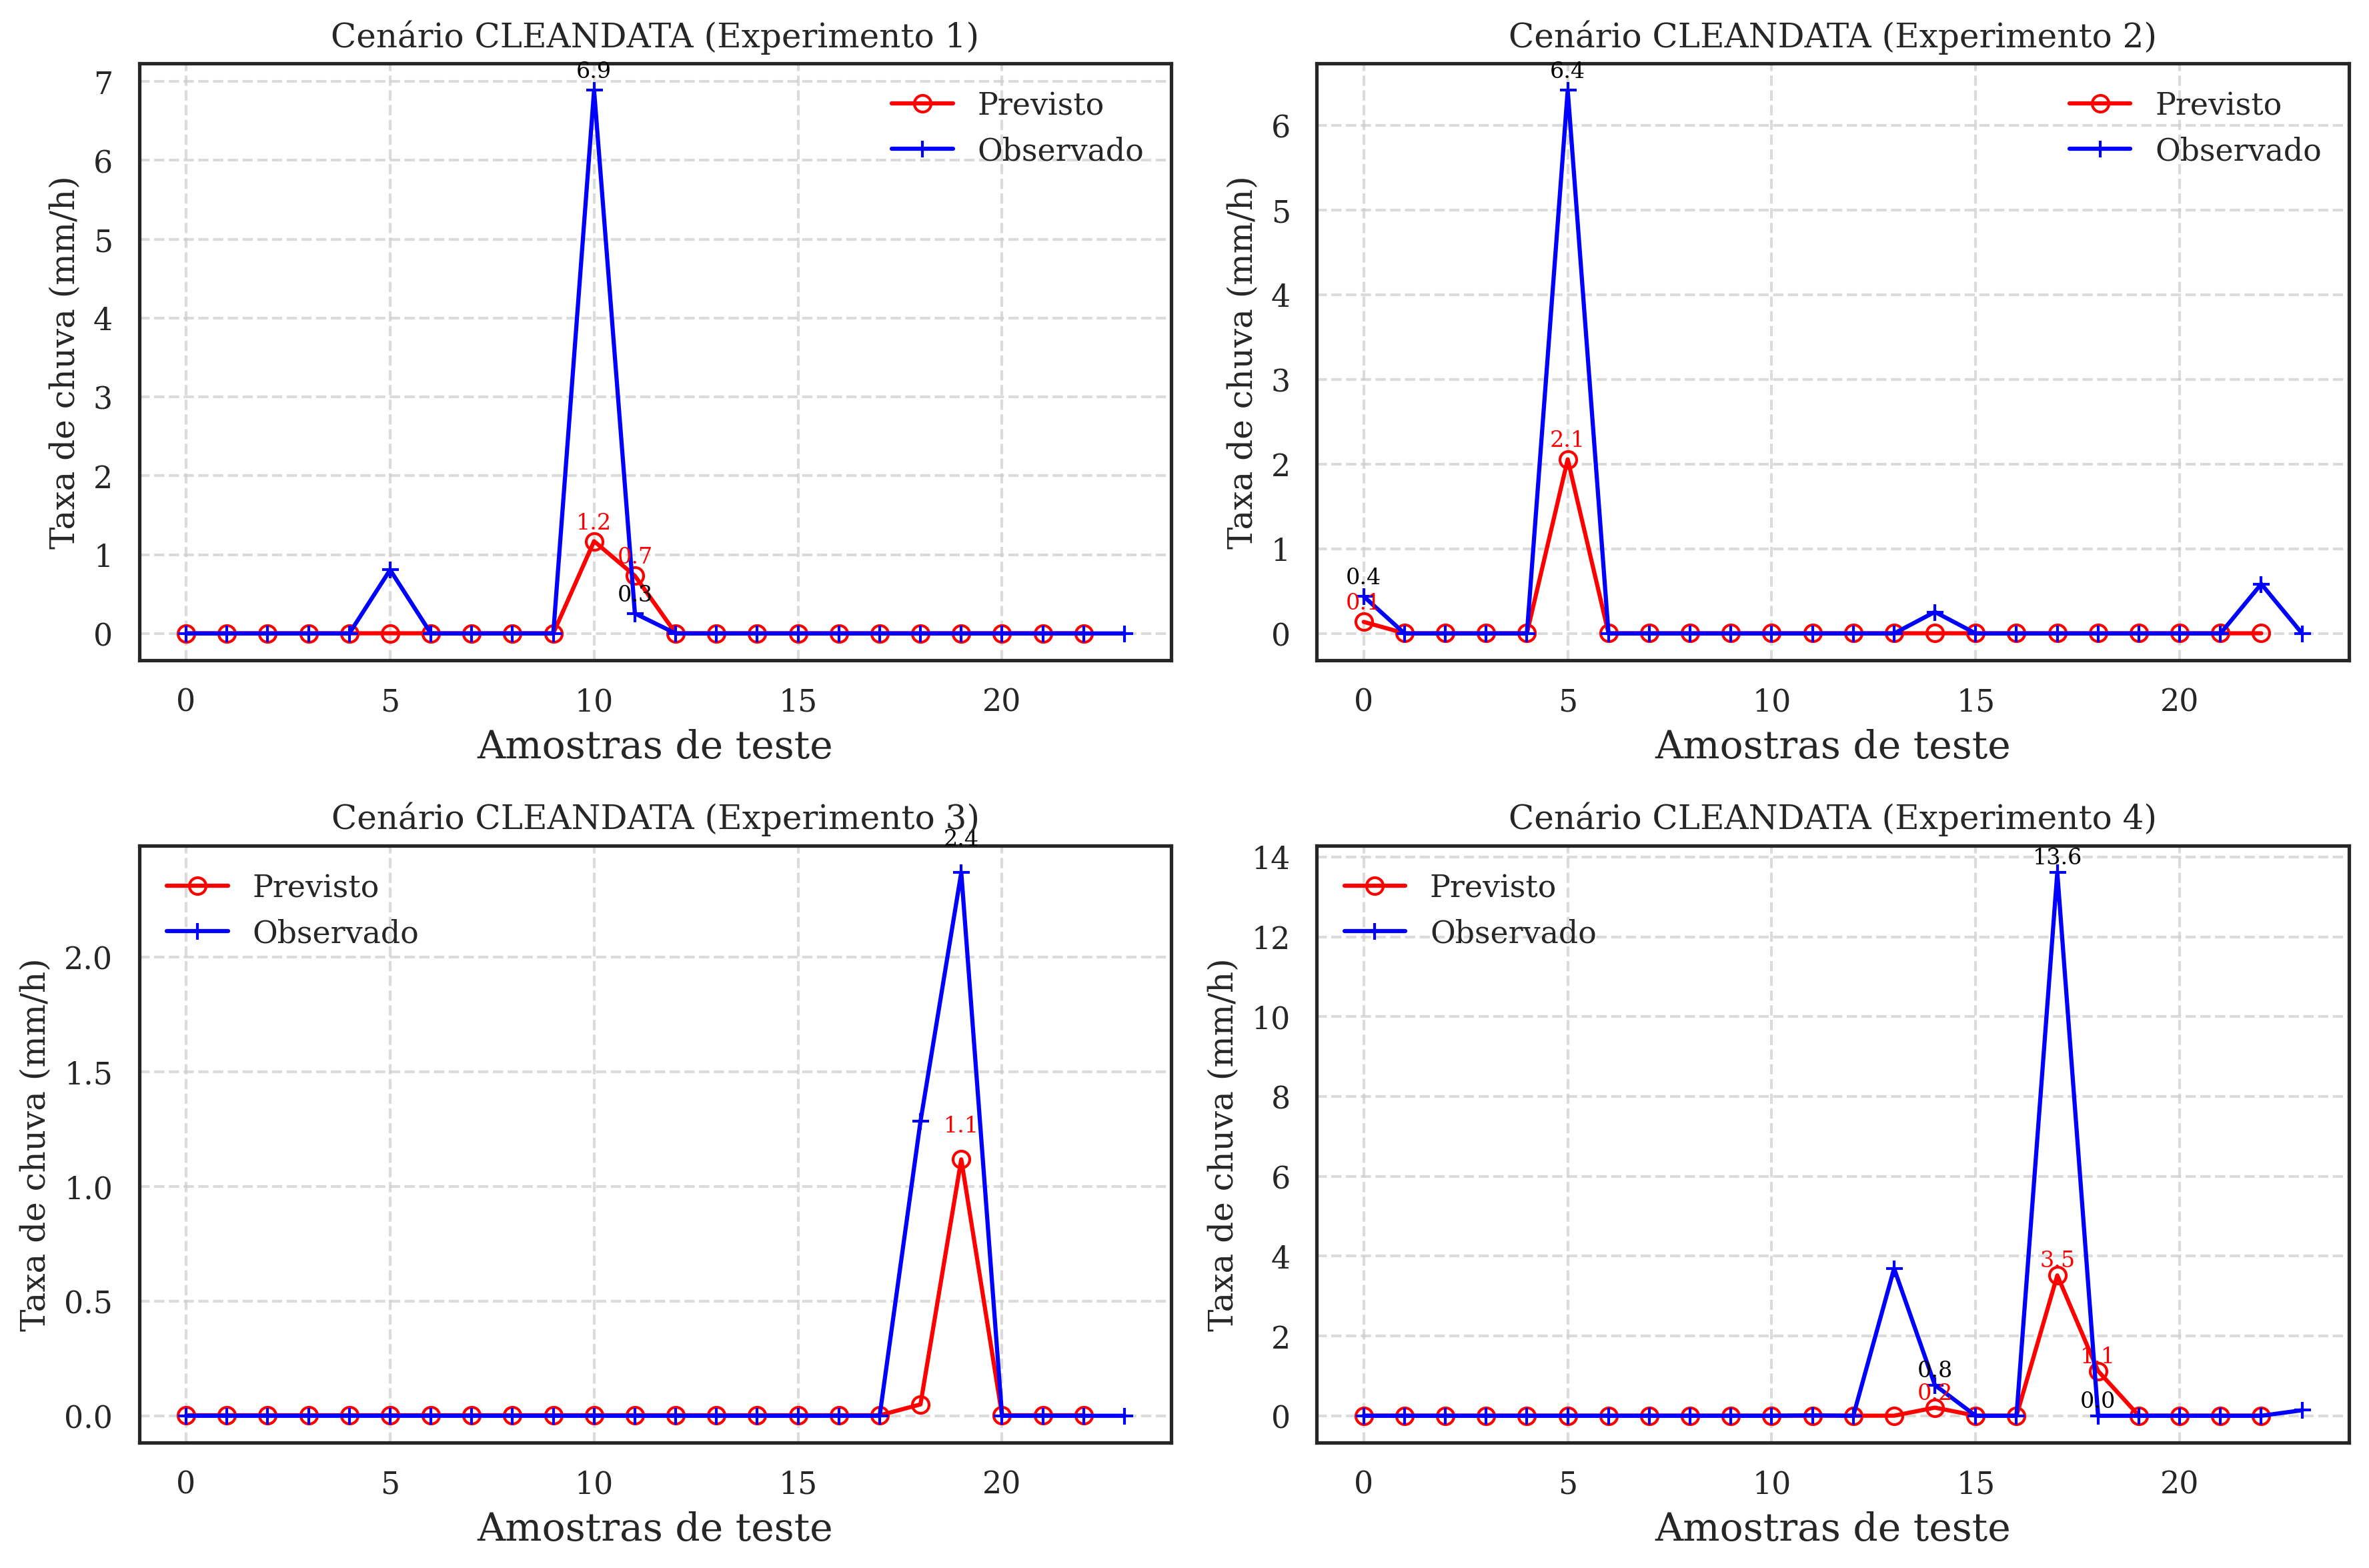

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Defina o número de amostras para cada experimento
sample_indices = [140, 170, 200, 230]

# Crie a figura e os eixos 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=300)

# Itere sobre cada subplot e conjunto de amostras
for idx, ax in enumerate(axs.flat):
    samples = sample_indices[idx]

    # Limite o número de amostras para cada subplot
    y_test_subset = y_test_0[samples:samples+24]
    y_pred_subset = y_pred_T0[samples:samples+24]

    # Crie um DataFrame com os dados observados e previstos
    df = pd.DataFrame({
        "Observed": y_test_subset.values.flatten(),
        "Predicted": y_pred_subset.flatten()
    })

    # Adicione o deslocamento para as previsões (1 hora à frente)
    df["Predicted"] = df["Predicted"].shift(-1)  # Desloca os valores previstos para o horário da previsão

    # Adicione o subplot para o gráfico de linhas
    ax.plot(df.index, df["Predicted"], linestyle='-', marker='o', markerfacecolor='none', color='red', label='Previsto')
    ax.plot(df.index, df["Observed"], linestyle='-', marker='+', color='blue', label='Observado')

    # Adicione rótulos e título para cada subplot
    ax.set_xlabel('Amostras de teste', fontsize=14)
    ax.set_ylabel('Taxa de chuva (mm/h)', fontsize=12)
    ax.set_title(f'Cenário CLEANDATA (Experimento {idx+1})', fontsize=12)

    # Ajuste a legenda e a grade
    ax.legend(frameon=False)  # Remove a borda da legenda
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adicionar valores acima dos pontos apenas se a previsão for maior ou igual a 0.1
    for i, (pred_val, obs_val) in enumerate(zip(df["Predicted"].dropna(), df["Observed"].dropna())):
        if pred_val >= 0.1:
            ax.text(df.index[i], pred_val + 0.1, f'{round(pred_val, 1)}', ha='center', va='bottom', color='red', fontsize=8)
            ax.text(df.index[i], obs_val + 0.1, f'{round(obs_val, 1)}', ha='center', va='bottom', color='black', fontsize=8)

plt.tight_layout()
plt.show()


In [73]:
print(len(y_pred_T0))

2867


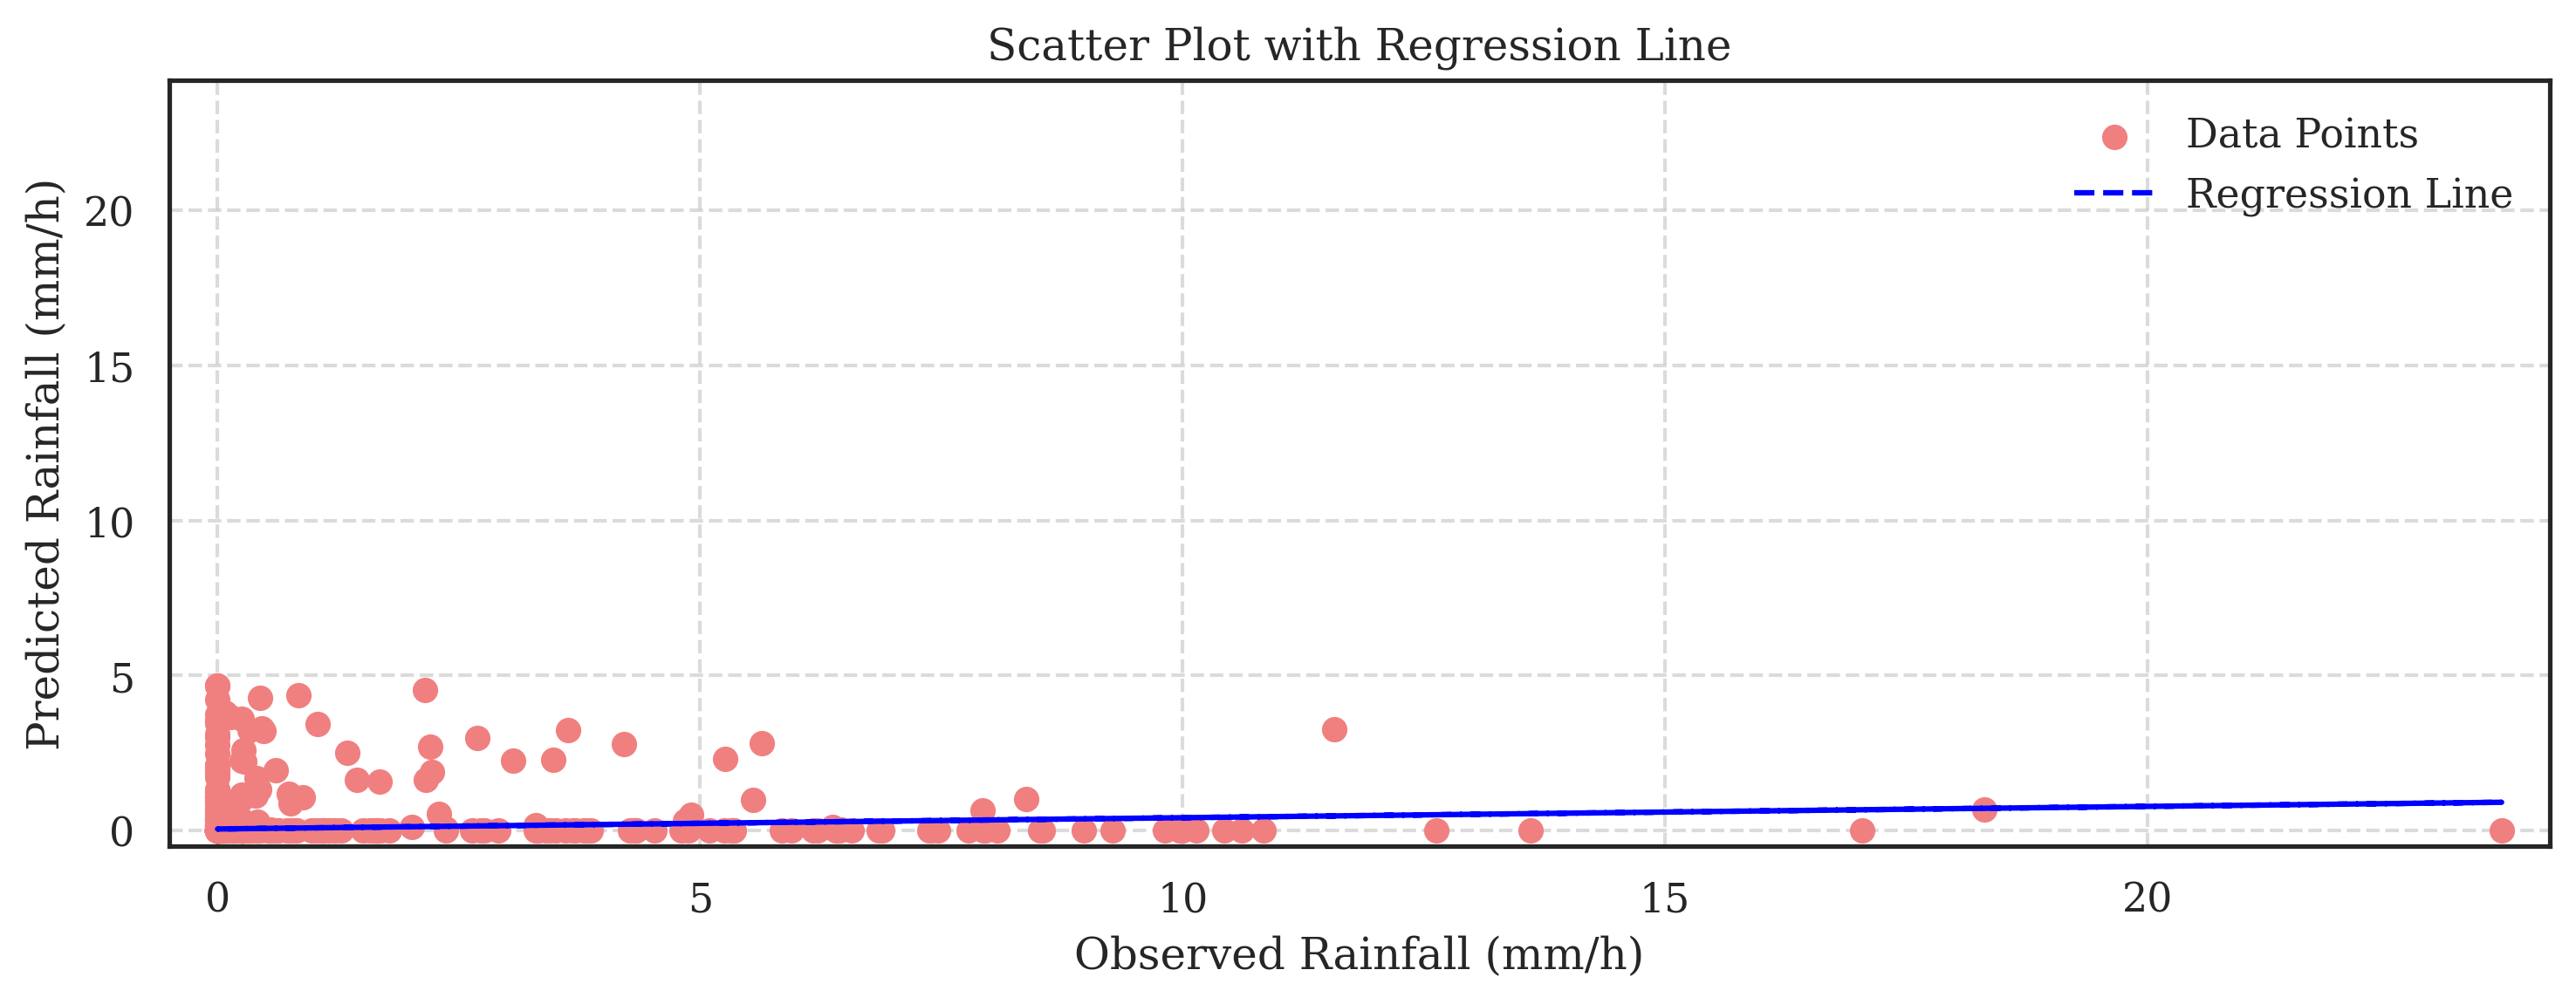

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Defina o número de amostras
samples = len(y_pred_T0)

# Limite o número de amostras
y_test = y_test_0[:]
y_pred = y_pred_T0[:]

# Crie um DataFrame com os dados observados e previstos
df = pd.DataFrame({
    "Observed": y_test.values.flatten(),
    "Predicted": y_pred.flatten()
})

# Calcule a linha de regressão
slope, intercept = np.polyfit(df["Observed"], df["Predicted"], 1)
regression_line = slope * df["Observed"] + intercept

# Crie a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

# Adicione o gráfico de dispersão
ax.scatter(df["Observed"], df["Predicted"], color='lightcoral', label='Data Points')

# Adicione a linha de regressão
ax.plot(df["Observed"], regression_line, color='blue', label='Regression Line', linestyle='--')

# Adicione rótulos e título
ax.set_xlabel('Observed Rainfall (mm/h)', fontsize=12)
ax.set_ylabel('Predicted Rainfall (mm/h)', fontsize=12)
ax.set_title('Scatter Plot with Regression Line', fontsize=12)

# Ajuste a legenda e a grade
ax.legend(frameon=False)  # Remove a borda da legenda
ax.grid(True, linestyle='--', alpha=0.7)

# Ajustar os limites dos eixos
ax.set_xlim(min(df["Observed"].min(), df["Predicted"].min()) - 0.5, max(df["Observed"].max(), df["Predicted"].max()) + 0.5)
ax.set_ylim(min(df["Observed"].min(), df["Predicted"].min()) - 0.5, max(df["Observed"].max(), df["Predicted"].max()) + 0.5)

plt.tight_layout()
plt.show()


In [75]:
# Calcular a média dos valores reais
y_mean = np.mean(y_test_0)
# Calcular a soma dos quadrados totais (SST)
sst = np.sum((y_test_0 - y_mean) ** 2)
# Calcular a soma dos quadrados de regressão (SSR)
ssr = np.sum((y_pred_T0 - y_mean) ** 2)
# Calcular o coeficiente de determinação R²
r_squared = 1 - (ssr / sst)

print(f"Coeficiente de Determinação (R²): {r_squared}")

Coeficiente de Determinação (R²): 0.8881622307917266


## **Test the model with data NOT SEEN in training**

In [76]:
import pandas as pd
import numpy as np

# Definir o número de amostras
num_samples = 2867

# Gerar uma sequência de datas e horas
date_range = pd.date_range(start='2023-06-04 13:00:00', periods=num_samples, freq='H')

# Gerar valores aleatórios de chuva entre 0.0 e 40.0
rainfall_values = np.random.uniform(0.0, 40.0, num_samples)

# Criar o DataFrame
df_test = pd.DataFrame({
    'Datetime': date_range,
    'Rainfall_mm_h_t1': rainfall_values
})

# Configurar a coluna Datetime como índice
df_test.set_index('Datetime', inplace=True)

# Exibir as primeiras linhas do DataFrame
print(df_test.head())

# Verificar o tamanho do DataFrame
print(f"Total de amostras: {len(df_test)}")


                     Rainfall_mm_h_t1
Datetime                             
2023-06-04 13:00:00         28.565683
2023-06-04 14:00:00          5.189194
2023-06-04 15:00:00         20.269986
2023-06-04 16:00:00         22.551160
2023-06-04 17:00:00         19.028879
Total de amostras: 2867


<ipython-input-76-e99d1225df68>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2023-06-04 13:00:00', periods=num_samples, freq='H')


In [77]:
print(y_test_0[24:48].index)

DatetimeIndex(['2023-06-05 13:00:00', '2023-06-05 14:00:00',
               '2023-06-05 15:00:00', '2023-06-05 16:00:00',
               '2023-06-05 17:00:00', '2023-06-05 18:00:00',
               '2023-06-05 19:00:00', '2023-06-05 20:00:00',
               '2023-06-05 21:00:00', '2023-06-05 22:00:00',
               '2023-06-05 23:00:00', '2023-06-06 00:00:00',
               '2023-06-06 01:00:00', '2023-06-06 02:00:00',
               '2023-06-06 03:00:00', '2023-06-06 04:00:00',
               '2023-06-06 05:00:00', '2023-06-06 06:00:00',
               '2023-06-06 07:00:00', '2023-06-06 08:00:00',
               '2023-06-06 09:00:00', '2023-06-06 10:00:00',
               '2023-06-06 11:00:00', '2023-06-06 12:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)


# Testar o modelo salvo

In [78]:
features

['Tamb_k',
 'Tir_K',
 '22.234GHz',
 '22.500GHz',
 '23.034GHz',
 '23.834GHz',
 '25.000GHz',
 '26.234GHz',
 '51.248GHz',
 '51.760GHz',
 '52.280GHz',
 '52.804GHz',
 '53.336GHz',
 '54.400GHz',
 '54.940GHz',
 '55.500GHz',
 '56.020GHz',
 '57.288GHz']

In [79]:
from keras.models import load_model
import numpy as np

# Carregar o modelo salvo
model = load_model('/content/Model_T0.h5')

# Preparar os novos dados de teste (substitua isso pelos seus próprios dados)
# Certifique-se de preparar os dados da mesma maneira que os dados de treinamento foram preparados
# Aqui, X_test é o conjunto de dados de teste
X_test = df_for_tests.copy()

# Normalizar/redimensionar os novos dados de teste, se necessário
# Se você normalizou/redimensionou os dados de treinamento, faça o mesmo para os dados de teste

# Selecionar apenas as colunas específicas que você deseja usar
X_test_selected = X_test[features]

# Fazer previsões nos novos dados de teste
# A saída será as previsões do modelo
predictions = model.predict(X_test_selected)

# Supondo que 'df_for_tests' contém apenas a coluna de chuva observada ('Rainfall_mm_h')
y_observed = df_for_tests['Rainfall_mm_h_t1'].values



# Remover linhas com valores NaN tanto das previsões quanto dos valores observados
y_observed_filled = np.nan_to_num(y_observed, nan=-999.99)
predictions_filled = np.nan_to_num(predictions, nan=-999.99)

# Calcular o MAE entre as previsões do modelo e os valores observados sem valores NaN
mae = mean_absolute_error(y_observed_filled, predictions_filled)

# Faça algo com o MAE, como imprimir
print(f'O erro médio absoluto (MAE) entre as previsões e os valores observados é: {mae}')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/Model_T0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Transformar predictions_filled em um array unidimensional
predictions_filled_flat = predictions_filled.flatten()

# Definir o número de barras (amostras)
num_bars = len(y_observed_filled[:48])

# Definir a largura das barras
bar_width = 0.35

# Criar um array com a posição das barras
index = np.arange(num_bars)

# Plotar os valores observados e previsões lado a lado
plt.figure(figsize=(13, 6))
predicted_bars = plt.bar(index, predictions_filled_flat[:48], bar_width, label='Previsões do Modelo', color='red')
observed_bars = plt.bar(index + bar_width, y_observed_filled[:48], bar_width, label='Valores Observados', color='blue')


plt.xlabel('Amostras')
plt.ylabel('Chuva')
plt.title('Comparação entre Valores Observados e Previsões')
plt.xticks(index + bar_width / 2, range(1, num_bars + 1))
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular o erro médio absoluto (MAE)
mae = mean_absolute_error(y_observed_filled, predictions_filled)

# Calcular o erro médio quadrático (MSE)
mse = mean_squared_error(y_observed_filled, predictions_filled)

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_observed_filled, predictions_filled)

print("Erro médio absoluto (MAE):", mae)
print("Erro médio quadrático (MSE):", mse)
print("Coeficiente de determinação (R²):", r2)


# **Other / Helpers**

## **Hyperparameter Optimization: Finding the Best Combination of Dropout, L2, and Momentum**

In this section of the notebook, the code iterates through different values of dropout, L2 regularization, and momentum to optimize the model's performance. The model is tJoss_RI_mmhed with these values, and the val_loss metric is calculated for each combination. The goal is to identify the combination that results in the lowest val_loss, indicating the best model performance on the validation set. This will allow us to select the optimal hyperparameters for the neural network architecture, thereby improving its ability to generalize and perform well on unseen data.

In [ ]:
executar_Hyperparameter_Optimization = True
if executar_Hyperparameter_Optimization:

  # Loop through different dropout, L2, and momentum values
  best_val_loss = float('inf')
  best_dropout = 0
  best_l2 = 0
  best_momentum = 0

    # Lista de valores de dropout
  dropout_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.15, 0.25, 0.35, 0.04, 0.08]

  # Lista de valores de l2_value
  l2_list = [0.001, 0.002, 0.003, 0.004, 0.01, 0.005, 0.007, 0.009, 0.015, 0.02]


  for dropout_value in dropout_list:
      for l2_value in l2_list:
              print(f"Testing dropout: {dropout_value}, L2: {l2_value}")

              # Build the MLP model with specified dropout, L2 regularization, and momentum
              model_T2 = Sequential()
              model_T2.add(Dense(len(features), input_shape=(X_train_0.shape[1],), activation='linear', kernel_regularizer=regularizers.l2(l2_value)))
              model_T2.add(Dropout(dropout_value))
              model_T2.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
              model_T2.add(Dropout(dropout_value))
              model_T2.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
              model_T2.add(Dropout(dropout_value))
              model_T2.add(Dense(1, activation='linear'))


              model_T2.compile(loss='mean_absolute_error', optimizer='adam')

              history_T2 = model_T2.fit(X_train_0, y_train_0, epochs=100, batch_size=batch_size_val, validation_data=(X_val_0, y_val_0), verbose=0)

              val_loss = model_T2.evaluate(X_val_0, y_val_0, verbose=0)

              if val_loss < best_val_loss:
                  best_val_loss = val_loss
                  best_dropout = dropout_value
                  best_l2 = l2_value

  print(f"Best Validation Loss: {best_val_loss}")
  print(f"Best Dropout: {best_dropout}")
  print(f"Best L2 Value: {best_l2}")


## **Model 01**

In [ ]:
# Define hyperparameters (OTHER)
execute_model1 = False
if execute_model1:

    EPOCHS_MODEL = 5000

    DROPOUT_MODEL_i = 0.2
    DROPOUT_MODEL_ii = 0.4
    DROPOUT_MODEL_iii = 0.8

    REGULARIZER_MODEL = 0.08

    learning_rate = 0.001

    momentum = 0.0012051591948107 #using optimizer SGD

    batch_size_val = 32


    patience_early_stop = 20

    executar_Hyperparameter_Optimization = False

    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        #mse = mean_squared_error(y_true, y_pred)
        #r2 = r2_score(y_true, y_pred)

        return {
            'MAE': [mae],
            #'MSE': [mse],
            'RMSE': [rmse]
            #'R²': [r2]
        }


    def tJoss_RI_mmh_and_predict_model(X_tJoss_RI_mmh, Y_tJoss_RI_mmh, x_val, y_val, X_test, y_test, dataset_name):
        tf.keras.backend.clear_session()

        model = Sequential()
        model.add(Dense(3, input_shape=(X_tJoss_RI_mmh.shape[1],),kernel_regularizer=l2(REGULARIZER_MODEL)))
        model.add(Dropout(DROPOUT_MODEL_i))

        model.add(Dense(200, activation='relu',kernel_regularizer=l2(REGULARIZER_MODEL)))
        model.add(Dropout(DROPOUT_MODEL_ii))

        model.add(Dense(200, activation='relu',))
        model.add(Dropout(DROPOUT_MODEL_iii))

        model.add(Dense(1, activation='linear'))

        #optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
        model.compile(loss='median_absolute_error', optimizer='adam', metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
        #mean_absolute_error
        early_stop = EarlyStopping(monitor='val_loss', patience=patience_early_stop, restore_best_weights=True)

        class PrintProgressAtInterval(Callback):
            def __init__(self, interval):
                super(PrintProgressAtInterval, self).__init__()
                self.interval = interval

            def on_epoch_end(self, epoch, logs=None):
                if (epoch + 1) % self.interval == 0:
                    print(f'Epoch {epoch+1}/{self.params["epochs"]} - {dataset_name}: Loss: {logs["loss"]:.4f},  Val Loss: {logs["val_loss"]:.4f}')

        print_progress = PrintProgressAtInterval(interval=1)

        history = model.fit(X_tJoss_RI_mmh, Y_tJoss_RI_mmh, validation_data=(x_val, y_val),
                            epochs=EPOCHS_MODEL, batch_size=batch_size_val,  callbacks=[early_stop, print_progress], verbose=0)

        model.save(f'Model_{dataset_name}_rna.h5')




        # Extract the last row of X_test
        last_sample = X_test[-1:]
        # Make the prediction for the last row
        current_forecast = model.predict(last_sample)

        y_pred = model.predict(X_test)

        metrics = calculate_metrics(y_test, y_pred)
        return history, y_pred, current_forecast, metrics

    print('\nTESTE 1 - Treinando o modelo, fazendo previsões e calculando as métricas')
    history_T0, y_pred_T0,current_forecast_0, metrics_T0 = tJoss_RI_mmh_and_predict_model(X_tJoss_RI_mmh_T0, Y_tJoss_RI_mmh_T0, x_val_T0, y_val_T0, X_test_T0, y_test_T0, 'T0')

    print('\nTESTE 2 - Treinando o modelo, fazendo previsões e calculando as métricas')
    history_T1, y_pred_T1, current_forecast_1, metrics_T1 = tJoss_RI_mmh_and_predict_model(X_tJoss_RI_mmh_T1, Y_tJoss_RI_mmh_T1, x_val_T1, y_val_T1, X_test_T1, y_test_T1, 'T1')

    print('\nTESTE 3 - Treinando o modelo, fazendo previsões e calculando as métricas')
    history_T2, y_pred_T2, current_forecast_2, metrics_T2 = tJoss_RI_mmh_and_predict_model(X_tJoss_RI_mmh_T2, Y_tJoss_RI_mmh_T2, x_val_T2, y_val_T2, X_test_T2, y_test_T2, 'T2')

    print(f'TESTE 1 - Previsão atual: {current_forecast_0}')
    print(f'TESTE 2 - Previsão atual: {current_forecast_1}')
    print(f'TESTE 3 - Previsão atual: {current_forecast_2}')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Dados fictícios para exemplo
np.random.seed(42)
data = np.random.normal(loc=10, scale=5, size=50)

# Parâmetros do histograma
bin_width = 0.5
bins = np.arange(min(data), max(data) + bin_width, bin_width)

# Plotar histograma
plt.hist(data, bins=bins, alpha=0.5, label='Histogram')

# Parâmetros da distribuição gama (ajuste seus valores conforme necessário)
alpha, loc, beta = 2, 0, 5

# Criar PDF da distribuição gama
x = np.linspace(min(data), max(data), 100)
pdf_gamma = gamma.pdf(x, alpha, loc, beta)

# Superpor PDF da distribuição gama multiplicado por 25
plt.plot(x, pdf_gamma * 25, 'k-', label='Gamma PDF (scaled)')

# Parâmetros da distribuição gaussiana (ajuste seus valores conforme necessário)
mu, sigma = np.mean(data), np.std(data)

# Criar PDF da distribuição gaussiana
pdf_gaussian = norm.pdf(x, mu, sigma)

# Superpor PDF da distribuição gaussiana multiplicado por 25
plt.plot(x, pdf_gaussian * 25, 'r--', label='Gaussian PDF (scaled)')

# Adicionar legendas e título
plt.legend()
plt.title('Superposition of PDFs onto a Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Mostrar o gráfico
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gamma, norm

# Suponha que você tenha um dataframe chamado df com uma coluna 'precipitation'
# Certifique-se de carregar seus dados reais aqui
# df = pd.read_csv('seuarquivo.csv')

# Use os dados reais da coluna 'precipitation'
data = df_final['Rainfall_mm_h'].values
data = data[(data >= 0.1) & (data <= 20)]

# Parâmetros do histograma
bin_width = 0.5
bins = np.arange(min(data), max(data) + bin_width, bin_width)

# Plotar histograma
plt.hist(data, bins=bins, alpha=0.5, label='Histogram')

# Parâmetros da distribuição gama (ajuste conforme necessário)
alpha, loc, beta = 2, 0, 5

# Criar PDF da distribuição gama
x = np.linspace(min(data), max(data), 100)
pdf_gamma = gamma.pdf(x, alpha, loc, beta)

# Superpor PDF da distribuição gama multiplicado por 25
plt.plot(x, pdf_gamma * len(data) * bin_width, 'k-', label='Gamma PDF (scaled)')

# Parâmetros da distribuição gaussiana (ajuste conforme necessário)
mu, sigma = np.mean(data), np.std(data)

# Criar PDF da distribuição gaussiana
pdf_gaussian = norm.pdf(x, mu, sigma)

# Superpor PDF da distribuição gaussiana multiplicado por 25
plt.plot(x, pdf_gaussian * len(data) * bin_width, 'r--', label='Gaussian PDF (scaled)')

# Adicionar legendas e título
plt.legend()
plt.title('Superposition of PDFs onto a Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Mostrar o gráfico
plt.show()


**REFERÊNCIAS**

[1] Meinrat Andreae et al. “The Amazon Tall Tower Observatory (ATTO): overview of pilot measurements on ecosystem ecology, meteorology, trace gases, and aerosols”. Em: Atmospheric Chemistry and Physics 15.18 (2015), pp. 10723–10776.

[2] L. J. Cavalcante Neto e A. J Calheiros. “A study on the impact of data balance on rain fall prediction through artificial neural networks using surface microwave radiometers”. Em: Latin-American Journal of Computing 11.2 (jul. de 2024), pp. 51–59. url: https: //lajc.epn.edu.ec/index.php/LAJC/article/view/394.

[3] Radiometrics Corporation. MP3000A Profiler Operator’s Manual. 2008.

[4] Emad Habib, Witold F Krajewski e Anton Kruger. “Sampling errors of tipping-bucket raingauge measurements”. Em: Journal of Hydrologic Engineering 6.2 (2001), pp. 159–166.

[5] S Hochreiter. “Long Short-term Memory”. Em: Neural Computation MIT-Press (1997).

[6] Tanvir Islam, Miguel A Rico-Ramirez, Dawei Han e Prashant K Srivastava. “A Joss–Waldvogel disdrometer derived rainfall estimation study by collocated tipping bucket and rapid response rain gauges”. Em: Atmospheric Science Letters 13.2 (2012), pp. 139–150.

[7] Martin Löffler-Mang e Jürg Joss. “An optical disdrometer for measuring size and velocity of hydrometeors”. Em: Journal of Atmospheric and Oceanic Technology 17.2 (2000), pp. 130–139.

[8] Qinghua Miao, Baoxiang Pan, Hao Wang, Kuolin Hsu e Soroosh Sorooshian. “Improving monsoon precipitation prediction using combined convolutional and long short term memory neural network”. Em: Water 11.5 (2019), p. 977.

[9] WORLD METEOROLOGICAL ORGANIZATION (WMO). Guide to meteorological instruments and methods of observation. 7th ed. ed. Geneva, Switzerland: World Meteorological Organization, 2008. OCLC: 288915903. ISBN 978-92-63-10008-5. 11, 12, 65, 66